# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


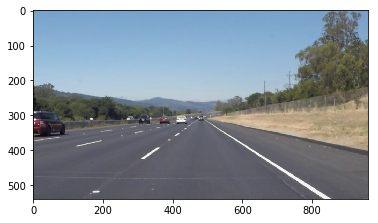

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

Thanks to Joao Sousa-Pinto for this link http://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

In [3]:
#class for storing and managing lane line data

class LaneLines:
    
    max_items = 20
    slopeThreshold_pct =  25
    interceptThreshold_pix = 75 
    y_top = 320
    y_bottom = 539
    min_slope = 0.25
    max_slope = 1
    slope_weight = 100
    intercept_weight = 1
    
    class Line:
        def __init__(self, slope, intercept):
            self.slope = slope
            self.intercept = intercept
            self.count = 0
            
    def __init__(self):
        self.leftLine = self.Line(0.6, 50)
        self.rightLine = self.Line(-0.8, 700)
        self.lineList = []
        
        
    def clearLineList(self):
        self.lineList = []
        
    def clearLeftRightLines(self):
        self.leftLine = self.Line(0.6, 50)
        self.rightLine = self.Line(-0.8, 700)
        
    def findLine(self, targetLine):
        bestIndex = 0
        bestCostFunction = 1e20
        for i in range(0,self.lineList.__len__()):
            line = self.lineList[i]
            
            slopeError = abs(line.slope - targetLine.slope)
            interceptError = abs(line.intercept - targetLine.intercept)
            costFunction = self.slope_weight * slopeError + self.intercept_weight *  interceptError
            
            if costFunction < bestCostFunction:
                bestIndex = i
                bestCostFunction = costFunction
        
        targetLine.count = targetLine.count + 1
        count = targetLine.count
        
        if targetLine.count > self.max_items:
            count = self.max_items
        
        
        print(count)
        targetLine.slope = targetLine.slope - targetLine.slope/count + self.lineList[bestIndex].slope/count
        targetLine.intercept = targetLine.intercept - targetLine.intercept/count + self.lineList[bestIndex].intercept/count
            
        
    def findLeftLine(self):
        self.findLine(self.leftLine)
        
    def findRightLine(self):
        self.findLine(self.rightLine)
        
    def findLines(self):
        self.findRightLine()
        self.findLeftLine()
        self.clearLineList()
    
    def addToLineList(self, slope, intercept):
        self.lineList.append(LaneLines.Line(slope,intercept))
                
    def drawLines(self, img, color, thickness):
        print ("Drawing Lines")
        
        for line in [self.leftLine, self.rightLine]:
            print ("combined: slope: " + str(line.slope) + " , intercept: " + str(line.intercept))
            
            if line.slope == 0:
                continue
            y1 = self.y_top
            y2 = self.y_bottom
            x1 = int((y1 - line.intercept) / line.slope)
            x2 = int((y2 - line.intercept) / line.slope)
            
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
        
                

In [4]:
import math
from scipy.stats import linregress


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_avglines(img, lines, color=[255, 0, 0], thickness=5):

    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept, r_value, p_value, std_err = linregress([x1,x2],[y1,y2]) 
            #print ("(" + str(x1) + ", " + str(y1) + ")" +", " + "(" + str(x2) + ", " + str(y2) + ")" )
            #print ("slope: " + str(slope) + " , intercept: " + str(intercept))
            laneLines.addToLineList(slope,intercept)
            
    laneLines.findLines()
    laneLines.drawLines(img, color, thickness)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines, thickness = 15)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Some Helper functions

In [6]:
def  newPlot(image, debugPlot = True):
    if(debugPlot):
        plt.figure()
        plt.imshow(image)

In [7]:
# function for running the pipeline



def pipeline(thingToProcess, debugPlot = True):
    print("Processsing " + thingToProcess)
    
    #reading in an image
    image = mpimg.imread('test_images/' + thingToProcess)
    
    #convert to grayscale
    gray = grayscale(image)
    if False: #if(debugPlot):
        plt.figure()
        plt.imshow(gray, cmap='gray')
    
    #gaussian blur
    blur_gray = gaussian_blur(gray, pipelineParameters.gaussianBlurKernelSize)
    if False: #if(debugPlot):
        plt.figure()
        plt.imshow(blur_gray, cmap='gray')
    
    #Canny Edge Detction
    edges = canny(blur_gray, pipelineParameters.cannyLowThreshold, pipelineParameters.cannyHighThreshold)
    if(False):
        plt.figure()
        plt.imshow(edges, cmap='gray')
        
    #mask   
    masked_edges = region_of_interest(edges, pipelineParameters.vertices)  
    if(False):
        plt.figure()
        plt.imshow(masked_edges, cmap='gray')
        
    #hough
    line_img, lines = hough_lines(masked_edges, pipelineParameters.houghRho, pipelineParameters.houghTheta, \
                        pipelineParameters.houghThreshold, pipelineParameters.houghMinLineLen, \
                        pipelineParameters.houghMaxLineGap)
    
    draw_avglines(line_img, lines, thickness = 15)
    
    if(False):
        plt.figure()
        plt.imshow(line_img, cmap='gray')
    
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    x = [pipelineParameters.maskCorner1[0], pipelineParameters.maskCorner2[0], pipelineParameters.maskCorner3[0], pipelineParameters.maskCorner4[0]]
    y = [pipelineParameters.maskCorner1[1], pipelineParameters.maskCorner2[1], pipelineParameters.maskCorner3[1], pipelineParameters.maskCorner4[1]]
    
    drawnLines = weighted_img(image,line_img)
    newPlot(drawnLines, debugPlot)
    #plt.plot(x, y, 'b--', lw=4)
    
    return

In [8]:
#pipeline parameters
class pipelineParameters:
    gaussianBlurKernelSize = 9
    
    cannyLowThreshold = 50
    cannyHighThreshold = 150
    
    #mask corners for 540/960
    maskCorner1 = (120, 539)
    maskCorner2 = (440, 320)
    maskCorner3 = (520, 320)
    maskCorner4 = (950, 539)
    
    #calculate mask corner ratios (ideally we can rely only on this, and not the other, but I'm adding this for the challenge and don't want to change non-challenge stuff at this point.)
    maskTop = 320/540
    maskBottom = 539/540
    maskLeftBottom = 120/960
    maskRightBottom = 950/960
    maskLeftTop = 440/960
    maskRightTop = 520/960
    
    vertices = np.array([[maskCorner1, maskCorner2, maskCorner3, maskCorner4]], dtype = np.int32)
    
    houghRho = 2
    houghTheta = np.pi/180
    houghThreshold = 50
    houghMinLineLen = 20
    houghMaxLineGap = 20
    
    video_height = 540
    video_width = 960
    
    @staticmethod
    def calculateVertices():

        pipelineParameters.maskCorner1 = (int(pipelineParameters.maskLeftBottom * pipelineParameters.video_width),
                                          int(pipelineParameters.maskBottom * pipelineParameters.video_height))
        pipelineParameters.maskCorner2 = (int(pipelineParameters.maskLeftTop * pipelineParameters.video_width),
                                          int(pipelineParameters.maskTop * pipelineParameters.video_height))
        pipelineParameters.maskCorner3 = (int(pipelineParameters.maskRightTop * pipelineParameters.video_width), 
                                          int(pipelineParameters.maskTop * pipelineParameters.video_height))
        pipelineParameters.maskCorner4 = (int(pipelineParameters.maskRightBottom * pipelineParameters.video_width), 
                                          int(pipelineParameters.maskBottom * pipelineParameters.video_height))

        pipelineParameters.vertices = np.array([[pipelineParameters.maskCorner1, pipelineParameters.maskCorner2, 
                                                 pipelineParameters.maskCorner3, pipelineParameters.maskCorner4]], dtype = np.int32)


    
    

Processsing solidWhiteCurve.jpg
1
1
Drawing Lines
combined: slope: 0.5625 , intercept: 40.6875
combined: slope: -0.830508474576 , intercept: 705.338983051
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidWhiteRight.jpg
1
1
Drawing Lines
combined: slope: 0.625 , intercept: 18.0
combined: slope: -0.714285714286 , intercept: 652.571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowCurve.jpg
1
1
Drawing Lines
combined: slope: 0.577777777778 , intercept: 42.8666666667
combined: slope: -0.777777777778 , intercept: 675.888888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowCurve2.jpg
1
1
Drawing Lines
combined: slope: 0.567567567568 , intercept: 39.2432432432
combined: slope: -0.777777777778 , intercept: 679.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowLeft.jpg
1
1
Drawing Lines
combined: slope: 0.598214285714

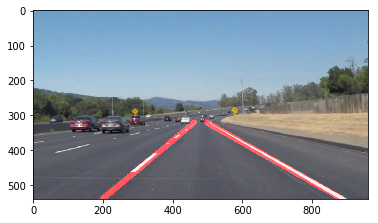

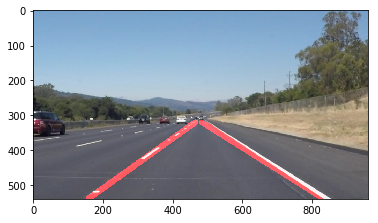

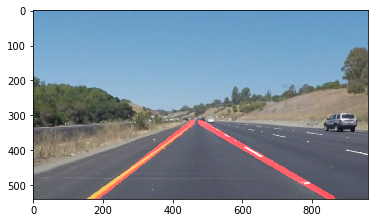

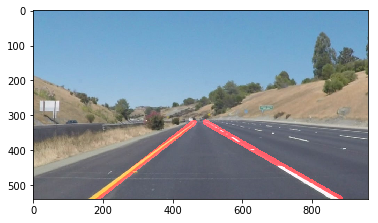

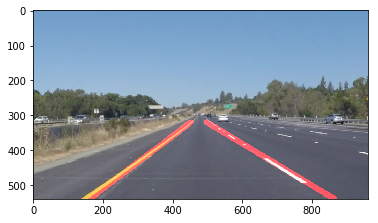

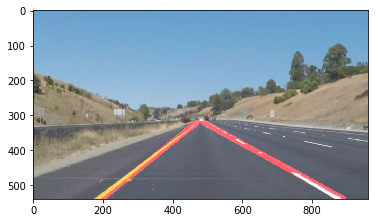

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


imageList = os.listdir("test_images/")
#imageList = [imageList[0]]

pipelineParameters.video_height = 540
pipelineParameters.video_width = 960
pipelineParameters.calculateVertices()


for image in imageList:
    laneLines = LaneLines()
    pipeline(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    #Read the image
    
    #reading in an image
    #image = mpimg.imread('test_images/' + thingToProcess)
    
    #convert to grayscale
    gray = grayscale(image)
    
    #gaussian blur
    blur_gray = gaussian_blur(gray, pipelineParameters.gaussianBlurKernelSize)
    
    #Canny Edge Detction
    edges = canny(blur_gray, pipelineParameters.cannyLowThreshold, pipelineParameters.cannyHighThreshold)
        
    #mask   
    masked_edges = region_of_interest(edges, pipelineParameters.vertices)  
        
    #hough
    line_img, lines = hough_lines(masked_edges, pipelineParameters.houghRho, pipelineParameters.houghTheta, \
                        pipelineParameters.houghThreshold, pipelineParameters.houghMinLineLen, \
                        pipelineParameters.houghMaxLineGap)
    
    draw_avglines(line_img, lines, thickness = 15)

    #printing out some stats and plotting
    x = [pipelineParameters.maskCorner1[0], pipelineParameters.maskCorner2[0], pipelineParameters.maskCorner3[0], pipelineParameters.maskCorner4[0]]
    y = [pipelineParameters.maskCorner1[1], pipelineParameters.maskCorner2[1], pipelineParameters.maskCorner3[1], pipelineParameters.maskCorner4[1]]
    
    
    drawnLines = weighted_img(image,line_img)
    
    color=[0, 255, 0]
    thickness=2
    
    for i in range(0,x.__len__()-1):
        y1 = y[i]
        y2 = y[i+1]
        x1 = x[i]
        x2 = x[i+1]
            
        cv2.line(drawnLines, (x1, y1), (x2, y2), color, thickness)
    #newPlot(drawnLines, debugPlot)
    #plt.plot(x, y, 'b--', lw=4)
    
    print('This image is:', type(image), 'with dimensions:', image.shape)
    
    return drawnLines

Let's try the one with the solid white lane on the right first ...

In [12]:
pipelineParameters.video_height = 540
pipelineParameters.video_width = 960
pipelineParameters.calculateVertices()

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
laneLines = LaneLines() #using a global variable? I know this hurts me too, but I can't figure out how to pass it to the process image function
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                                                                                                       | 0/222 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|██▏                                                                                                                                                            | 3/222 [00:00<00:09, 22.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|████▎                                                                                                                                                          | 6/222 [00:00<00:08, 24.04it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  4%|██████▍                                                                                                                                                        | 9/222 [00:00<00:08, 25.17it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|█████████▎                                                                                                                                                    | 13/222 [00:00<00:07, 26.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  7%|███████████▍                                                                                                                                                  | 16/222 [00:00<00:07, 27.43it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|██████████████▏                                                                                                                                               | 20/222 [00:00<00:07, 28.38it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|████████████████▎                                                                                                                                             | 23/222 [00:00<00:06, 28.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|██████████████████▌                                                                                                                                           | 26/222 [00:00<00:06, 28.75it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 13%|████████████████████▋                                                                                                                                         | 29/222 [00:01<00:06, 27.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|██████████████████████▊                                                                                                                                       | 32/222 [00:01<00:07, 25.17it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|████████████████████████▉                                                                                                                                     | 35/222 [00:01<00:07, 23.82it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|███████████████████████████                                                                                                                                   | 38/222 [00:01<00:07, 23.02it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|█████████████████████████████▏                                                                                                                                | 41/222 [00:01<00:08, 21.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|███████████████████████████████▎                                                                                                                              | 44/222 [00:01<00:08, 21.74it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|█████████████████████████████████▍                                                                                                                            | 47/222 [00:02<00:11, 15.35it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|███████████████████████████████████▌                                                                                                                          | 50/222 [00:02<00:09, 17.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|█████████████████████████████████████▋                                                                                                                        | 53/222 [00:02<00:13, 12.28it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|███████████████████████████████████████▏                                                                                                                      | 55/222 [00:02<00:13, 12.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|████████████████████████████████████████▌                                                                                                                     | 57/222 [00:02<00:12, 13.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|█████████████████████████████████████████▉                                                                                                                    | 59/222 [00:03<00:14, 11.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|███████████████████████████████████████████▍                                                                                                                  | 61/222 [00:03<00:13, 11.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|████████████████████████████████████████████▊                                                                                                                 | 63/222 [00:03<00:13, 11.92it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 29%|██████████████████████████████████████████████▎                                                                                                               | 65/222 [00:03<00:12, 12.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|███████████████████████████████████████████████▋                                                                                                              | 67/222 [00:03<00:11, 13.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|█████████████████████████████████████████████████▊                                                                                                            | 70/222 [00:03<00:10, 13.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|███████████████████████████████████████████████████▏                                                                                                          | 72/222 [00:04<00:11, 13.07it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 34%|█████████████████████████████████████████████████████▍                                                                                                        | 75/222 [00:04<00:09, 14.77it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|██████████████████████████████████████████████████████▊                                                                                                       | 77/222 [00:04<00:09, 15.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 36%|████████████████████████████████████████████████████████▏                                                                                                     | 79/222 [00:04<00:08, 16.18it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 82/222 [00:04<00:08, 16.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 84/222 [00:04<00:09, 15.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|█████████████████████████████████████████████████████████████▉                                                                                                | 87/222 [00:04<00:07, 16.89it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|███████████████████████████████████████████████████████████████▎                                                                                              | 89/222 [00:05<00:08, 16.55it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|████████████████████████████████████████████████████████████████▊                                                                                             | 91/222 [00:05<00:08, 15.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|██████████████████████████████████████████████████████████████████▉                                                                                           | 94/222 [00:05<00:07, 17.55it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|████████████████████████████████████████████████████████████████████▎                                                                                         | 96/222 [00:05<00:07, 17.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                        | 98/222 [00:05<00:07, 15.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 101/222 [00:05<00:07, 16.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 103/222 [00:05<00:07, 15.66it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 106/222 [00:06<00:06, 17.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 108/222 [00:06<00:07, 15.00it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 110/222 [00:06<00:12,  9.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 113/222 [00:06<00:09, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 115/222 [00:07<00:11,  9.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 117/222 [00:07<00:13,  8.03it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 119/222 [00:07<00:12,  8.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 121/222 [00:07<00:10,  9.94it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 123/222 [00:07<00:10,  9.29it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 125/222 [00:08<00:09,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 128/222 [00:08<00:08, 10.94it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 131/222 [00:08<00:06, 13.24it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 133/222 [00:08<00:06, 13.42it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 135/222 [00:08<00:06, 13.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 138/222 [00:08<00:05, 14.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 140/222 [00:08<00:05, 15.55it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 143/222 [00:09<00:04, 17.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 145/222 [00:09<00:05, 15.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 147/222 [00:09<00:04, 15.06it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 150/222 [00:09<00:04, 17.04it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 152/222 [00:09<00:04, 14.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 155/222 [00:09<00:04, 16.41it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 157/222 [00:09<00:03, 16.67it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 159/222 [00:10<00:03, 16.75it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 161/222 [00:10<00:03, 17.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 163/222 [00:10<00:03, 16.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 166/222 [00:10<00:03, 17.47it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 168/222 [00:10<00:03, 15.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 171/222 [00:10<00:03, 16.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 173/222 [00:10<00:03, 14.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 175/222 [00:11<00:03, 15.12it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 178/222 [00:11<00:02, 16.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 180/222 [00:11<00:02, 16.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 182/222 [00:11<00:02, 15.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 185/222 [00:11<00:02, 16.97it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 187/222 [00:11<00:02, 16.24it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 189/222 [00:11<00:01, 17.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 192/222 [00:12<00:01, 15.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 195/222 [00:12<00:01, 17.27it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 198/222 [00:12<00:01, 18.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 200/222 [00:12<00:01, 15.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 203/222 [00:12<00:01, 16.50it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 205/222 [00:12<00:01, 15.47it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 207/222 [00:12<00:00, 16.58it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 209/222 [00:13<00:00, 16.75it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 211/222 [00:13<00:00, 14.84it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 214/222 [00:13<00:00, 16.08it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 217/222 [00:13<00:00, 16.16it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 220/222 [00:13<00:00, 17.96it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 221/222 [00:13<00:00, 16.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 14.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
pipelineParameters.video_height = 540
pipelineParameters.video_width = 960
pipelineParameters.calculateVertices()

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

1
1
Drawing Lines
combined: slope: 0.644859813084 , intercept: -3.83177570093
combined: slope: -0.629032258065 , intercept: 616.258064516
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                                                                                                       | 0/682 [00:00<?, ?it/s]

2
2
Drawing Lines
combined: slope: 0.644859813084 , intercept: -3.83177570093
combined: slope: -0.629032258065 , intercept: 616.258064516
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
3
3
Drawing Lines
combined: slope: 0.644192256342 , intercept: -3.50689808634
combined: slope: -0.628531626834 , intercept: 616.170693483
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  0%|▍                                                                                                                                                              | 2/682 [00:00<00:45, 14.80it/s]

4
4
Drawing Lines
combined: slope: 0.646367332752 , intercept: -5.16116530029
combined: slope: -0.628423513514 , intercept: 616.421408542
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
5
5
Drawing Lines
combined: slope: 0.646505630908 , intercept: -5.37599106376
combined: slope: -0.631664430646 , intercept: 616.700763197
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|▉                                                                                                                                                              | 4/682 [00:00<00:43, 15.60it/s]

6
6
Drawing Lines
combined: slope: 0.645897549566 , intercept: -5.02761160075
combined: slope: -0.630553692205 , intercept: 615.688135998
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
7
7
Drawing Lines
combined: slope: 0.64546320575 , intercept: -4.5032589231
combined: slope: -0.630950783795 , intercept: 615.546973712
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|█▍                                                                                                                                                             | 6/682 [00:00<00:41, 16.25it/s]

8
8
Drawing Lines
combined: slope: 0.646676856756 , intercept: -4.88000673012
combined: slope: -0.630539382629 , intercept: 615.212644551
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
9
9
Drawing Lines
combined: slope: 0.646895944744 , intercept: -5.56901499134
combined: slope: -0.630237178878 , intercept: 615.06119783
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|█▊                                                                                                                                                             | 8/682 [00:00<00:39, 17.04it/s]

10
10
Drawing Lines
combined: slope: 0.645620984416 , intercept: -5.3389427605
combined: slope: -0.629905768683 , intercept: 614.867770355
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
11
11
Drawing Lines
combined: slope: 0.647534228257 , intercept: -6.48994796409
combined: slope: -0.629682606111 , intercept: 614.760361642
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|██▎                                                                                                                                                           | 10/682 [00:00<00:37, 17.69it/s]

12
12
Drawing Lines
combined: slope: 0.647245358953 , intercept: -6.82906246991
combined: slope: -0.62964351253 , intercept: 614.755050606
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
13
13
Drawing Lines
combined: slope: 0.6487393057 , intercept: -7.68836535684
combined: slope: -0.631086459758 , intercept: 615.188012994
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  2%|██▊                                                                                                                                                           | 12/682 [00:00<00:36, 18.17it/s]

14
14
Drawing Lines
combined: slope: 0.64695523931 , intercept: -6.88389230094
combined: slope: -0.631796401277 , intercept: 615.339418659
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
15
15
Drawing Lines
combined: slope: 0.646880445578 , intercept: -6.65968836976
combined: slope: -0.632269233784 , intercept: 615.4186426
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  2%|███▏                                                                                                                                                          | 14/682 [00:00<00:36, 18.44it/s]

16
16
Drawing Lines
combined: slope: 0.6468915942 , intercept: -6.54860490548
combined: slope: -0.633148748136 , intercept: 615.791105486
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
17
17
Drawing Lines
combined: slope: 0.646934385578 , intercept: -6.47823879059
combined: slope: -0.635458456664 , intercept: 616.475807192
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  2%|███▋                                                                                                                                                          | 16/682 [00:00<00:35, 18.69it/s]

18
18
Drawing Lines
combined: slope: 0.647318372704 , intercept: -7.00295202017
combined: slope: -0.635595822098 , intercept: 616.814315988
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
19
19
Drawing Lines
combined: slope: 0.646387386226 , intercept: -6.40240678714
combined: slope: -0.637773723304 , intercept: 617.600178539
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|████▏                                                                                                                                                         | 18/682 [00:00<00:35, 18.82it/s]

20
20
Drawing Lines
combined: slope: 0.646826637604 , intercept: -6.97021748227
combined: slope: -0.639414448904 , intercept: 618.180169612
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.645913877153 , intercept: -6.68599232244
combined: slope: -0.6411849852 , intercept: 618.759972321
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|████▋                                                                                                                                                         | 20/682 [00:01<00:34, 19.10it/s]

20
20
Drawing Lines
combined: slope: 0.645669465346 , intercept: -6.52092347555
combined: slope: -0.642858612652 , intercept: 619.242179184
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.645204173897 , intercept: -6.40396821086
combined: slope: -0.64444349267 , intercept: 619.699596852
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|█████                                                                                                                                                         | 22/682 [00:01<00:39, 16.65it/s]

20
20
Drawing Lines
combined: slope: 0.644975215202 , intercept: -6.36033230032
combined: slope: -0.645971318037 , intercept: 620.103367009
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.645079395619 , intercept: -6.4129039206
combined: slope: -0.647189235652 , intercept: 620.422374483
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  4%|█████▌                                                                                                                                                        | 24/682 [00:01<00:39, 16.63it/s]

20
20
Drawing Lines
combined: slope: 0.645178367014 , intercept: -6.46284695986
combined: slope: -0.648265356691 , intercept: 620.81505944
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.644737630482 , intercept: -6.28515915732
combined: slope: -0.648505150081 , intercept: 621.180428917
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  4%|██████                                                                                                                                                        | 26/682 [00:01<00:41, 15.83it/s]

20
20
Drawing Lines
combined: slope: 0.644887112594 , intercept: -6.45896938128
combined: slope: -0.648879892577 , intercept: 621.525807471
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.644642756964 , intercept: -6.49002091221
combined: slope: -0.650253325334 , intercept: 622.083956932
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  4%|██████▍                                                                                                                                                       | 28/682 [00:01<00:42, 15.51it/s]

20
20
Drawing Lines
combined: slope: 0.643660619116 , intercept: -6.2655198666
combined: slope: -0.651570446301 , intercept: 622.615929298
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.64224681893 , intercept: -5.50224387327
combined: slope: -0.65292974782 , intercept: 623.13150589
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  4%|██████▉                                                                                                                                                       | 30/682 [00:01<00:43, 14.90it/s]

20
20
Drawing Lines
combined: slope: 0.639166736048 , intercept: -4.05938974412
combined: slope: -0.654857728515 , intercept: 623.784505063
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637511429548 , intercept: -3.12763237813
combined: slope: -0.65594568786 , intercept: 624.29925991
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  5%|███████▍                                                                                                                                                      | 32/682 [00:01<00:43, 14.85it/s]

20
20
Drawing Lines
combined: slope: 0.637711329769 , intercept: -3.45709981583
combined: slope: -0.658333588652 , intercept: 625.015778396
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636260545889 , intercept: -2.99511439025
combined: slope: -0.660101593904 , intercept: 625.694268755
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  5%|███████▉                                                                                                                                                      | 34/682 [00:02<00:44, 14.69it/s]

20
20
Drawing Lines
combined: slope: 0.635216749364 , intercept: -2.81458943997
combined: slope: -0.662273505359 , intercept: 626.495396025
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.635274093714 , intercept: -2.99204178615
combined: slope: -0.66428803522 , intercept: 627.249344173
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  5%|████████▎                                                                                                                                                     | 36/682 [00:02<00:42, 15.13it/s]

20
20
Drawing Lines
combined: slope: 0.634938960457 , intercept: -3.25672541113
combined: slope: -0.666629189014 , intercept: 628.013543631
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634442012434 , intercept: -3.29388914058
combined: slope: -0.669012015278 , intercept: 628.762866449
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|████████▊                                                                                                                                                     | 38/682 [00:02<00:45, 14.29it/s]

20
20
Drawing Lines
combined: slope: 0.634719911812 , intercept: -3.75119468355
combined: slope: -0.670561414514 , intercept: 629.149723127
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634650582888 , intercept: -3.85530161604
combined: slope: -0.672227518546 , intercept: 629.680586485
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|█████████▎                                                                                                                                                    | 40/682 [00:02<00:45, 14.06it/s]

20
20
Drawing Lines
combined: slope: 0.634497001112 , intercept: -3.90201021944
combined: slope: -0.673042372126 , intercept: 630.054753882
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634022151057 , intercept: -3.69440970847
combined: slope: -0.675259818738 , intercept: 630.653103145
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|█████████▋                                                                                                                                                    | 42/682 [00:02<00:44, 14.44it/s]

20
20
Drawing Lines
combined: slope: 0.632321043504 , intercept: -3.02968922305
combined: slope: -0.676689960848 , intercept: 631.038259146
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.631008021632 , intercept: -2.19790173159
combined: slope: -0.677990597941 , intercept: 631.410670513
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|██████████▏                                                                                                                                                   | 44/682 [00:02<00:46, 13.77it/s]

20
20
Drawing Lines
combined: slope: 0.63227012055 , intercept: -2.83175664501
combined: slope: -0.678813290266 , intercept: 631.67485921
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.632363931596 , intercept: -2.81333954447
combined: slope: -0.679594847975 , intercept: 631.910560694
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  7%|██████████▋                                                                                                                                                   | 46/682 [00:02<00:46, 13.56it/s]

20
20
Drawing Lines
combined: slope: 0.631995735016 , intercept: -2.49142256725
combined: slope: -0.68067257684 , intercept: 632.333423464
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.631229281599 , intercept: -1.89185143888
combined: slope: -0.682497533857 , intercept: 632.902105826
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  7%|███████████                                                                                                                                                   | 48/682 [00:03<00:48, 12.95it/s]

20
20
Drawing Lines
combined: slope: 0.631246764887 , intercept: -2.20515360378
combined: slope: -0.684622657164 , intercept: 633.449500535
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.631502608461 , intercept: -2.49489592359
combined: slope: -0.686718054918 , intercept: 634.042739794
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  7%|███████████▌                                                                                                                                                  | 50/682 [00:03<00:44, 14.08it/s]

20
20
Drawing Lines
combined: slope: 0.632185542554 , intercept: -2.9443446758
combined: slope: -0.68605562156 , intercept: 634.073255865
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63190537935 , intercept: -2.6895325053
combined: slope: -0.686938025667 , intercept: 634.336259738
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  8%|████████████                                                                                                                                                  | 52/682 [00:04<02:38,  3.98it/s]

20
20
Drawing Lines
combined: slope: 0.631317862321 , intercept: -2.22869929089
combined: slope: -0.68775372601 , intercept: 634.547698784
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.631195268174 , intercept: -2.0512849449
combined: slope: -0.687436836169 , intercept: 634.50040234
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  8%|████████████▌                                                                                                                                                 | 54/682 [00:04<02:12,  4.74it/s]

20
20
Drawing Lines
combined: slope: 0.631268157826 , intercept: -2.12627171806
combined: slope: -0.68818404198 , intercept: 634.697406033
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.630061892792 , intercept: -1.47174384645
combined: slope: -0.688889343698 , intercept: 634.848795273
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  8%|████████████▉                                                                                                                                                 | 56/682 [00:04<01:48,  5.79it/s]

20
20
Drawing Lines
combined: slope: 0.629203959443 , intercept: -1.0465437509
combined: slope: -0.689546917329 , intercept: 634.990845306
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.627952094804 , intercept: -0.350466563354
combined: slope: -0.689181720996 , intercept: 634.940368461
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|█████████████▍                                                                                                                                                | 58/682 [00:05<01:30,  6.86it/s]

20
20
Drawing Lines
combined: slope: 0.627110045619 , intercept: 0.0448345425914
combined: slope: -0.689763618552 , intercept: 635.06916971
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.62686565445 , intercept: 0.135926148795
combined: slope: -0.690311933975 , intercept: 635.15585721
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|█████████████▉                                                                                                                                                | 60/682 [00:05<01:23,  7.49it/s]

20
20
Drawing Lines
combined: slope: 0.627101319096 , intercept: 0.321235104513
combined: slope: -0.690796337276 , intercept: 635.198064349
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.626996253141 , intercept: 0.611423349288
combined: slope: -0.691256520412 , intercept: 635.213161132
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|██████████████▎                                                                                                                                               | 62/682 [00:05<01:12,  8.49it/s]

20
20
Drawing Lines
combined: slope: 0.626468358292 , intercept: 0.847975469494
combined: slope: -0.691653043985 , intercept: 635.15697462
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.626963122196 , intercept: 0.70557669602
combined: slope: -0.691870391786 , intercept: 635.081925889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|██████████████▊                                                                                                                                               | 64/682 [00:05<01:03,  9.68it/s]

20
20
Drawing Lines
combined: slope: 0.627096447567 , intercept: 0.707334898256
combined: slope: -0.692276872197 , intercept: 635.087829595
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.627448942262 , intercept: 0.748797421636
combined: slope: -0.692424933349 , intercept: 635.045342877
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|███████████████▎                                                                                                                                              | 66/682 [00:05<01:00, 10.12it/s]

20
20
Drawing Lines
combined: slope: 0.627894676967 , intercept: 0.493175732372
combined: slope: -0.692603686681 , intercept: 635.045475733
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.628318124937 , intercept: 0.273062400299
combined: slope: -0.692973502347 , intercept: 635.108201946
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|███████████████▊                                                                                                                                              | 68/682 [00:06<01:04,  9.58it/s]

20
20
Drawing Lines
combined: slope: 0.62966083938 , intercept: -0.219901064544
combined: slope: -0.692237870708 , intercept: 634.916704892
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.629756744779 , intercept: -0.243116537632
combined: slope: -0.691600336147 , intercept: 634.724715802
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|████████████████▏                                                                                                                                             | 70/682 [00:06<01:02,  9.85it/s]

20
20
Drawing Lines
combined: slope: 0.629221288493 , intercept: 0.0809440511542
combined: slope: -0.691697738695 , intercept: 634.708641302
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.628611287898 , intercept: 0.430088337958
combined: slope: -0.690827137474 , intercept: 634.525780665
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|████████████████▋                                                                                                                                             | 72/682 [00:06<01:01,  9.90it/s]

20
20
Drawing Lines
combined: slope: 0.628536655706 , intercept: 0.498414429535
combined: slope: -0.690088597502 , intercept: 634.364280364
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.629718518573 , intercept: 0.0474067515363
combined: slope: -0.689455135369 , intercept: 634.270259895
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█████████████████▏                                                                                                                                            | 74/682 [00:06<01:03,  9.63it/s]

20
20
Drawing Lines
combined: slope: 0.630549665815 , intercept: -0.0994757811624
combined: slope: -0.689556846685 , intercept: 634.32961924
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.631233720986 , intercept: -0.136328915181
combined: slope: -0.689112617797 , intercept: 634.232045841
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█████████████████▌                                                                                                                                            | 76/682 [00:06<01:14,  8.13it/s]

20
20
Drawing Lines
combined: slope: 0.631777298095 , intercept: -0.170038785212
combined: slope: -0.689334406262 , intercept: 634.275282259
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█████████████████▊                                                                                                                                            | 77/682 [00:07<01:16,  7.94it/s]

20
20
Drawing Lines
combined: slope: 0.632410655412 , intercept: -0.239314623729
combined: slope: -0.688985333007 , intercept: 634.18975344
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63260830446 , intercept: -0.0818943470878
combined: slope: -0.689587612749 , intercept: 634.302430717
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|██████████████████▎                                                                                                                                           | 79/682 [00:07<01:04,  9.35it/s]

20
20
Drawing Lines
combined: slope: 0.632977889237 , intercept: -0.0777996297335
combined: slope: -0.689802109662 , intercept: 634.325064283
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634021302467 , intercept: -0.689294263631
combined: slope: -0.689927388795 , intercept: 634.347272607
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|██████████████████▊                                                                                                                                           | 81/682 [00:07<01:10,  8.47it/s]

20
20
Drawing Lines
combined: slope: 0.634138419162 , intercept: -0.518465914086
combined: slope: -0.69004640397 , intercept: 634.272216669
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634482780255 , intercept: -0.777158002997
combined: slope: -0.689614880232 , intercept: 634.055066013
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|███████████████████▏                                                                                                                                          | 83/682 [00:07<01:11,  8.38it/s]

20
20
Drawing Lines
combined: slope: 0.634980863465 , intercept: -0.871633436181
combined: slope: -0.689657945744 , intercept: 634.003503188
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63505000211 , intercept: -1.03259721892
combined: slope: -0.690114807493 , intercept: 634.026219595
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|███████████████████▋                                                                                                                                          | 85/682 [00:07<01:02,  9.59it/s]

20
20
Drawing Lines
combined: slope: 0.635328752004 , intercept: -0.976279857971
combined: slope: -0.689922792609 , intercept: 634.296477243
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.635562314404 , intercept: -0.869465865073
combined: slope: -0.689426652978 , intercept: 634.227653381
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 13%|████████████████████▏                                                                                                                                         | 87/682 [00:08<00:57, 10.27it/s]

20
20
Drawing Lines
combined: slope: 0.636231007194 , intercept: -1.02439682714
combined: slope: -0.688705320329 , intercept: 633.863770712
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636772398011 , intercept: -1.12611816225
combined: slope: -0.688885438928 , intercept: 633.77442833
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 13%|████████████████████▌                                                                                                                                         | 89/682 [00:08<00:58, 10.19it/s]

20
20
Drawing Lines
combined: slope: 0.636145899323 , intercept: -0.899812254139
combined: slope: -0.688153288194 , intercept: 633.42737358
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636156786175 , intercept: -0.786639823251
combined: slope: -0.687453488953 , intercept: 633.156566699
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 13%|█████████████████████                                                                                                                                         | 91/682 [00:08<00:52, 11.18it/s]

20
20
Drawing Lines
combined: slope: 0.635662078179 , intercept: -0.538721973502
combined: slope: -0.687803036727 , intercept: 633.300127253
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63587897427 , intercept: -0.615785874827
combined: slope: -0.687241267729 , intercept: 633.151952573
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|█████████████████████▌                                                                                                                                        | 93/682 [00:08<00:49, 11.82it/s]

20
20
Drawing Lines
combined: slope: 0.635566507038 , intercept: -0.320181766271
combined: slope: -0.686612081055 , intercept: 633.032026177
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636046246202 , intercept: -0.46868880699
combined: slope: -0.686764235623 , intercept: 633.058011075
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|██████████████████████                                                                                                                                        | 95/682 [00:08<00:51, 11.37it/s]

20
20
Drawing Lines
combined: slope: 0.637002554582 , intercept: -0.959047470088
combined: slope: -0.68624420566 , intercept: 633.022019613
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637761122505 , intercept: -1.08066031398
combined: slope: -0.685894259528 , intercept: 632.944503538
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|██████████████████████▍                                                                                                                                       | 97/682 [00:08<00:49, 11.90it/s]

20
20
Drawing Lines
combined: slope: 0.637787959997 , intercept: -0.794712404659
combined: slope: -0.685423075963 , intercept: 632.86492542
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637716743815 , intercept: -0.432249511699
combined: slope: -0.684935705949 , intercept: 632.783841311
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 15%|██████████████████████▉                                                                                                                                       | 99/682 [00:09<00:46, 12.63it/s]

20
20
Drawing Lines
combined: slope: 0.637463559686 , intercept: -0.406555403461
combined: slope: -0.68445275829 , intercept: 632.670295002
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636454579232 , intercept: 0.147722983996
combined: slope: -0.684089769498 , intercept: 632.591692532
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 15%|███████████████████████▎                                                                                                                                     | 101/682 [00:09<00:48, 12.06it/s]

20
20
Drawing Lines
combined: slope: 0.636707321969 , intercept: 0.274299098947
combined: slope: -0.684444104553 , intercept: 632.719460847
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637118332682 , intercept: 0.304062404869
combined: slope: -0.684076065992 , intercept: 632.603800305
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 15%|███████████████████████▋                                                                                                                                     | 103/682 [00:09<00:50, 11.39it/s]

20
20
Drawing Lines
combined: slope: 0.637080597866 , intercept: 0.366132011898
combined: slope: -0.683616105057 , intercept: 632.477304871
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637291785364 , intercept: 0.505434106956
combined: slope: -0.683147421016 , intercept: 632.279954779
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 15%|████████████████████████▏                                                                                                                                    | 105/682 [00:09<00:45, 12.71it/s]

20
20
Drawing Lines
combined: slope: 0.636677196096 , intercept: 0.967662401608
combined: slope: -0.68366746932 , intercept: 632.260311878
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63587781905 , intercept: 1.23824479877
combined: slope: -0.683221120075 , intercept: 632.084320506
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|████████████████████████▋                                                                                                                                    | 107/682 [00:09<00:42, 13.65it/s]

20
20
Drawing Lines
combined: slope: 0.636842548787 , intercept: 0.545298076072
combined: slope: -0.682775660402 , intercept: 631.954645765
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636428992776 , intercept: 1.00517602941
combined: slope: -0.682297008101 , intercept: 631.888286026
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|█████████████████████████                                                                                                                                    | 109/682 [00:09<00:51, 11.23it/s]

20
20
Drawing Lines
combined: slope: 0.63675040028 , intercept: 1.00848865651
combined: slope: -0.681866368222 , intercept: 631.835976988
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636912880266 , intercept: 1.11006422369
combined: slope: -0.680898049811 , intercept: 631.649178138
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|█████████████████████████▌                                                                                                                                   | 111/682 [00:10<00:45, 12.64it/s]

20
20
Drawing Lines
combined: slope: 0.637567236253 , intercept: 0.549561012502
combined: slope: -0.68056355456 , intercept: 631.634592534
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637633318885 , intercept: 0.709582961877
combined: slope: -0.68020884622 , intercept: 631.635515969
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|██████████████████████████                                                                                                                                   | 113/682 [00:10<00:44, 12.91it/s]

20
20
Drawing Lines
combined: slope: 0.638138016577 , intercept: 0.593421995601
combined: slope: -0.680056671626 , intercept: 631.676181115
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.638558701955 , intercept: 0.489612964787
combined: slope: -0.679912105761 , intercept: 631.714813005
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|██████████████████████████▍                                                                                                                                  | 115/682 [00:10<00:45, 12.54it/s]

20
20
Drawing Lines
combined: slope: 0.639004867576 , intercept: 0.300384115109
combined: slope: -0.679641990669 , intercept: 631.683190001
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.638872806016 , intercept: 0.280819454808
combined: slope: -0.679344101662 , intercept: 631.665346291
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|██████████████████████████▉                                                                                                                                  | 117/682 [00:10<00:44, 12.77it/s]

20
20
Drawing Lines
combined: slope: 0.637850218347 , intercept: 0.64112058733
combined: slope: -0.679114760656 , intercept: 631.653680918
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637439188911 , intercept: 0.631286780186
combined: slope: -0.678827364332 , intercept: 631.642604912
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|███████████████████████████▍                                                                                                                                 | 119/682 [00:10<00:50, 11.18it/s]

20
20
Drawing Lines
combined: slope: 0.637048710947 , intercept: 0.764537255992
combined: slope: -0.678722203012 , intercept: 631.679871218
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636624846828 , intercept: 0.806310393192
combined: slope: -0.678496500101 , intercept: 631.681624264
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|███████████████████████████▊                                                                                                                                 | 121/682 [00:10<00:45, 12.36it/s]

20
20
Drawing Lines
combined: slope: 0.636936461629 , intercept: 0.701709159247
combined: slope: -0.67852229238 , intercept: 631.680876384
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637004532165 , intercept: 0.80279391405
combined: slope: -0.67830404293 , intercept: 631.749641554
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|████████████████████████████▎                                                                                                                                | 123/682 [00:10<00:42, 13.14it/s]

20
20
Drawing Lines
combined: slope: 0.636235386638 , intercept: 1.02751908321
combined: slope: -0.678126704861 , intercept: 631.819198311
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.636566474449 , intercept: 0.933285986195
combined: slope: -0.677199093022 , intercept: 631.769727757
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|████████████████████████████▊                                                                                                                                | 125/682 [00:11<00:50, 10.95it/s]

20
20
Drawing Lines
combined: slope: 0.636922058772 , intercept: 0.834897548954
combined: slope: -0.678121747067 , intercept: 632.111676152
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637376840789 , intercept: 0.64846240602
combined: slope: -0.677251373999 , intercept: 632.130199487
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 19%|█████████████████████████████▏                                                                                                                               | 127/682 [00:11<00:47, 11.61it/s]

20
20
Drawing Lines
combined: slope: 0.636605559726 , intercept: 0.904453919865
combined: slope: -0.677165401044 , intercept: 632.190976747
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637562166985 , intercept: 0.366608273052
combined: slope: -0.677546261426 , intercept: 632.417297475
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 19%|█████████████████████████████▋                                                                                                                               | 129/682 [00:11<00:47, 11.72it/s]

20
20
Drawing Lines
combined: slope: 0.637826915779 , intercept: 0.216135002257
combined: slope: -0.676545660684 , intercept: 632.343692875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.638078427133 , intercept: 0.21961396643
combined: slope: -0.677455219755 , intercept: 632.628613494
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 19%|██████████████████████████████▏                                                                                                                              | 131/682 [00:11<00:42, 12.88it/s]

20
20
Drawing Lines
combined: slope: 0.638174505776 , intercept: 0.260633268108
combined: slope: -0.677446095131 , intercept: 632.73968282
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637996549718 , intercept: 0.368755450857
combined: slope: -0.677414094557 , intercept: 632.778744306
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|██████████████████████████████▌                                                                                                                              | 133/682 [00:11<00:46, 11.76it/s]

20
20
Drawing Lines
combined: slope: 0.638041166677 , intercept: 0.451706567203
combined: slope: -0.677350208011 , intercept: 632.819636636
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.637846425416 , intercept: 0.687657824208
combined: slope: -0.677203627843 , intercept: 632.900747828
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|███████████████████████████████                                                                                                                              | 135/682 [00:11<00:41, 13.18it/s]

20
20
Drawing Lines
combined: slope: 0.638096961288 , intercept: 0.617560647284
combined: slope: -0.677241751535 , intercept: 632.916727385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.63845017774 , intercept: 0.457650356855
combined: slope: -0.677407441736 , intercept: 633.025752127
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|███████████████████████████████▌                                                                                                                             | 137/682 [00:12<00:45, 12.00it/s]

20
20
Drawing Lines
combined: slope: 0.638719449675 , intercept: 0.435452770519
combined: slope: -0.677360599061 , intercept: 633.111229227
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.639392172843 , intercept: 0.0745496972105
combined: slope: -0.677370120129 , intercept: 633.184035112
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|███████████████████████████████▉                                                                                                                             | 139/682 [00:12<00:43, 12.44it/s]

20
20
Drawing Lines
combined: slope: 0.639565421344 , intercept: -0.0184635019358
combined: slope: -0.677685287592 , intercept: 633.306976214
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.639405332095 , intercept: -0.0902675995663
combined: slope: -0.677506380355 , intercept: 633.311493475
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|████████████████████████████████▍                                                                                                                            | 141/682 [00:12<00:47, 11.46it/s]

20
20
Drawing Lines
combined: slope: 0.63993506549 , intercept: -0.308254219588
combined: slope: -0.677522274726 , intercept: 633.376253529
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.640514069791 , intercept: -0.658750599518
combined: slope: -0.67736175732 , intercept: 633.378771128
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|████████████████████████████████▉                                                                                                                            | 143/682 [00:12<00:46, 11.54it/s]

20
20
Drawing Lines
combined: slope: 0.640631223445 , intercept: -0.67224164097
combined: slope: -0.677317198866 , intercept: 633.361303159
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.640266328939 , intercept: -0.371962892255
combined: slope: -0.677186278682 , intercept: 633.27878017
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|█████████████████████████████████▍                                                                                                                           | 145/682 [00:12<00:44, 12.08it/s]

20
20
Drawing Lines
combined: slope: 0.640395869635 , intercept: -0.392650461928
combined: slope: -0.677076964748 , intercept: 633.341091162
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.64004274282 , intercept: -0.419684605498
combined: slope: -0.67722311651 , intercept: 633.348036604
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|█████████████████████████████████▊                                                                                                                           | 147/682 [00:13<00:44, 12.12it/s]

20
20
Drawing Lines
combined: slope: 0.640262827901 , intercept: -0.450922597446
combined: slope: -0.677212892362 , intercept: 633.319765208
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.640325158204 , intercept: -0.393470807196
combined: slope: -0.677260293721 , intercept: 633.344006833
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|██████████████████████████████████▎                                                                                                                          | 149/682 [00:13<00:46, 11.49it/s]

20
20
Drawing Lines
combined: slope: 0.640741332726 , intercept: -0.57785132089
combined: slope: -0.677299718059 , intercept: 633.374855272
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.641021339261 , intercept: -0.719690462163
combined: slope: -0.677258261568 , intercept: 633.382583096
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|██████████████████████████████████▊                                                                                                                          | 151/682 [00:13<00:42, 12.39it/s]

20
20
Drawing Lines
combined: slope: 0.640051353379 , intercept: -0.449922155271
combined: slope: -0.677161582256 , intercept: 633.363453942
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.640306850226 , intercept: -0.567748628153
combined: slope: -0.677232074571 , intercept: 633.420281244
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|███████████████████████████████████▏                                                                                                                         | 153/682 [00:13<00:38, 13.57it/s]

20
20
Drawing Lines
combined: slope: 0.64086726529 , intercept: -0.978755136139
combined: slope: -0.677105410602 , intercept: 633.418544291
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.639593132795 , intercept: 0.000951851437327
combined: slope: -0.676583473405 , intercept: 633.430950409
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|███████████████████████████████████▋                                                                                                                         | 155/682 [00:13<00:46, 11.38it/s]

20
20
Drawing Lines
combined: slope: 0.638382706925 , intercept: 0.76628887425
combined: slope: -0.676538083519 , intercept: 633.541835321
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.638463571578 , intercept: 0.783974430538
combined: slope: -0.676504282791 , intercept: 633.766122866
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|████████████████████████████████████▏                                                                                                                        | 157/682 [00:13<00:42, 12.43it/s]

20
20
Drawing Lines
combined: slope: 0.636227892999 , intercept: 2.24165070901
combined: slope: -0.676557573324 , intercept: 634.021508311
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.634146228079 , intercept: 3.61335195734
combined: slope: -0.675765408944 , intercept: 634.016861467
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|████████████████████████████████████▌                                                                                                                        | 159/682 [00:13<00:40, 12.97it/s]

20
20
Drawing Lines
combined: slope: 0.63270207457 , intercept: 4.61952646474
combined: slope: -0.674955861901 , intercept: 634.113890734
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.630874663149 , intercept: 5.8587424492
combined: slope: -0.674541402139 , intercept: 634.324862864
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|█████████████████████████████████████                                                                                                                        | 161/682 [00:14<00:45, 11.55it/s]

20
20
Drawing Lines
combined: slope: 0.630478470975 , intercept: 6.12482172018
combined: slope: -0.674730415948 , intercept: 634.672955385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.6306618645 , intercept: 5.90394648783
combined: slope: -0.673346836327 , intercept: 634.580484087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|█████████████████████████████████████▌                                                                                                                       | 163/682 [00:14<00:40, 12.92it/s]

20
20
Drawing Lines
combined: slope: 0.630378771275 , intercept: 6.00249916344
combined: slope: -0.674679494511 , intercept: 635.211459882
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.628704793951 , intercept: 7.05935094945
combined: slope: -0.675667742008 , intercept: 635.767553555
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|█████████████████████████████████████▉                                                                                                                       | 165/682 [00:14<00:36, 14.04it/s]

20
20
Drawing Lines
combined: slope: 0.627269554254 , intercept: 7.55638340198
combined: slope: -0.674920069193 , intercept: 635.747925877
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.625497913276 , intercept: 8.28468668086
combined: slope: -0.676042486786 , intercept: 636.324345373
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|██████████████████████████████████████▍                                                                                                                      | 167/682 [00:14<00:42, 12.16it/s]

20
20
Drawing Lines
combined: slope: 0.625283623673 , intercept: 8.23257355894
combined: slope: -0.677180121483 , intercept: 636.893670273
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.62259087106 , intercept: 9.5066591667
combined: slope: -0.67833916595 , intercept: 637.516856795
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|██████████████████████████████████████▉                                                                                                                      | 169/682 [00:14<00:41, 12.32it/s]

20
20
Drawing Lines
combined: slope: 0.621818470365 , intercept: 9.91704049408
combined: slope: -0.677755540986 , intercept: 637.657680622
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.620727546846 , intercept: 10.4811884694
combined: slope: -0.678982267754 , intercept: 638.293117202
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|███████████████████████████████████████▎                                                                                                                     | 171/682 [00:15<00:47, 10.80it/s]

20
20
Drawing Lines
combined: slope: 0.619954327399 , intercept: 10.8650237828
combined: slope: -0.680135195182 , intercept: 638.929889913
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.619348767892 , intercept: 10.8139294564
combined: slope: -0.681128435423 , intercept: 639.503395417
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|███████████████████████████████████████▊                                                                                                                     | 173/682 [00:15<00:41, 12.19it/s]

20
20
Drawing Lines
combined: slope: 0.619083083883 , intercept: 10.7855136853
combined: slope: -0.682072013652 , intercept: 639.963225646
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.618843215403 , intercept: 10.7205237153
combined: slope: -0.683022760795 , intercept: 640.57892306
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|████████████████████████████████████████▎                                                                                                                    | 175/682 [00:15<00:40, 12.42it/s]

20
20
Drawing Lines
combined: slope: 0.617676335532 , intercept: 11.2946098891
combined: slope: -0.685121622756 , intercept: 641.517476907
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.617561749524 , intercept: 11.0337255485
combined: slope: -0.685480926233 , intercept: 642.010833831
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|████████████████████████████████████████▋                                                                                                                    | 177/682 [00:15<00:40, 12.37it/s]

20
20
Drawing Lines
combined: slope: 0.616749021525 , intercept: 11.3555686828
combined: slope: -0.687550492256 , intercept: 642.975049848
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.616226531079 , intercept: 11.3940894613
combined: slope: -0.689536604007 , intercept: 643.803570083
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|█████████████████████████████████████████▏                                                                                                                   | 179/682 [00:15<00:39, 12.65it/s]

20
20
Drawing Lines
combined: slope: 0.615849987134 , intercept: 11.5591675969
combined: slope: -0.691651952578 , intercept: 644.806408339
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.614819392539 , intercept: 11.9490663599
combined: slope: -0.693532237045 , intercept: 645.70124076
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|█████████████████████████████████████████▋                                                                                                                   | 181/682 [00:15<00:41, 12.11it/s]

20
20
Drawing Lines
combined: slope: 0.613110680977 , intercept: 12.8612904613
combined: slope: -0.693704110041 , intercept: 646.020724177
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609482173955 , intercept: 14.7817394517
combined: slope: -0.696518904539 , intercept: 647.119687968
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|██████████████████████████████████████████▏                                                                                                                  | 183/682 [00:15<00:39, 12.52it/s]

20
20
Drawing Lines
combined: slope: 0.606949241728 , intercept: 16.0779465968
combined: slope: -0.699107925299 , intercept: 648.195336223
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605173208213 , intercept: 17.1454778384
combined: slope: -0.700846077421 , intercept: 649.035972637
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|██████████████████████████████████████████▌                                                                                                                  | 185/682 [00:16<00:37, 13.25it/s]

20
20
Drawing Lines
combined: slope: 0.603861916223 , intercept: 17.9355723675
combined: slope: -0.703091909143 , intercept: 649.935021463
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602773298024 , intercept: 18.6081967342
combined: slope: -0.704630862073 , intercept: 650.691496196
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|███████████████████████████████████████████                                                                                                                  | 187/682 [00:16<00:41, 11.98it/s]

20
20
Drawing Lines
combined: slope: 0.602098918837 , intercept: 18.9474297547
combined: slope: -0.706899318969 , intercept: 651.544421387
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60144602769 , intercept: 19.2507431984
combined: slope: -0.708958933173 , intercept: 652.375597264
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|███████████████████████████████████████████▌                                                                                                                 | 189/682 [00:16<00:38, 12.77it/s]

20
20
Drawing Lines
combined: slope: 0.600540392972 , intercept: 19.7215393718
combined: slope: -0.7086961717 , intercept: 652.38644703
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59968003999 , intercept: 20.2812957366
combined: slope: -0.710261363115 , intercept: 652.952124679
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|███████████████████████████████████████████▉                                                                                                                 | 191/682 [00:16<00:40, 12.19it/s]

20
20
Drawing Lines
combined: slope: 0.599287874725 , intercept: 20.4407003375
combined: slope: -0.709933480144 , intercept: 652.967481408
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597656814322 , intercept: 21.5553319873
combined: slope: -0.712202763584 , intercept: 653.790383933
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|████████████████████████████████████████████▍                                                                                                                | 193/682 [00:16<00:43, 11.37it/s]

20
20
Drawing Lines
combined: slope: 0.596107306939 , intercept: 22.3192320546
combined: slope: -0.713826667958 , intercept: 654.266822183
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596301941592 , intercept: 22.3532704519
combined: slope: -0.715813905989 , intercept: 654.93419536
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 29%|████████████████████████████████████████████▉                                                                                                                | 195/682 [00:16<00:38, 12.74it/s]

20
20
Drawing Lines
combined: slope: 0.594865222891 , intercept: 23.3450663887
combined: slope: -0.71727811265 , intercept: 655.458073827
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594191729188 , intercept: 23.8580456274
combined: slope: -0.717525318129 , intercept: 655.618503469
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 29%|█████████████████████████████████████████████▎                                                                                                               | 197/682 [00:17<00:38, 12.75it/s]

20
20
Drawing Lines
combined: slope: 0.592784029521 , intercept: 24.5953320253
combined: slope: -0.717958576032 , intercept: 655.698887819
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591833352636 , intercept: 25.3557293585
combined: slope: -0.719402419382 , intercept: 656.162044694
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 29%|█████████████████████████████████████████████▊                                                                                                               | 199/682 [00:17<00:41, 11.51it/s]

20
20
Drawing Lines
combined: slope: 0.592003589766 , intercept: 25.434371462
combined: slope: -0.720274403676 , intercept: 656.356574039
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592064427227 , intercept: 25.5473986516
combined: slope: -0.719626537151 , intercept: 655.942403873
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 29%|██████████████████████████████████████████████▎                                                                                                              | 201/682 [00:17<00:37, 12.70it/s]

20
20
Drawing Lines
combined: slope: 0.59149346393 , intercept: 26.070028719
combined: slope: -0.719852106845 , intercept: 656.010800921
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590814894629 , intercept: 26.7158779324
combined: slope: -0.721413149571 , intercept: 656.41927375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|██████████████████████████████████████████████▋                                                                                                              | 203/682 [00:17<00:37, 12.88it/s]

20
20
Drawing Lines
combined: slope: 0.590948946646 , intercept: 26.7894336293
combined: slope: -0.722780915738 , intercept: 656.810379028
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591279548094 , intercept: 26.7444741429
combined: slope: -0.722511435169 , intercept: 656.729642686
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|███████████████████████████████████████████████▏                                                                                                             | 205/682 [00:17<00:38, 12.47it/s]

20
20
Drawing Lines
combined: slope: 0.591025915517 , intercept: 27.1882849186
combined: slope: -0.722859293362 , intercept: 656.7697306
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590784964569 , intercept: 27.370249983
combined: slope: -0.723003954112 , intercept: 656.804989889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|███████████████████████████████████████████████▋                                                                                                             | 207/682 [00:17<00:37, 12.82it/s]

20
20
Drawing Lines
combined: slope: 0.59093321634 , intercept: 27.5282999838
combined: slope: -0.723201274137 , intercept: 656.789385785
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590798320229 , intercept: 27.6312967493
combined: slope: -0.723358777998 , intercept: 656.769680009
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 31%|████████████████████████████████████████████████                                                                                                             | 209/682 [00:18<00:42, 11.02it/s]

20
20
Drawing Lines
combined: slope: 0.59104563826 , intercept: 27.3720723374
combined: slope: -0.723601988923 , intercept: 656.743391131
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591038810893 , intercept: 27.5693778114
combined: slope: -0.723545237495 , intercept: 656.585957257
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 31%|████████████████████████████████████████████████▌                                                                                                            | 211/682 [00:18<00:38, 12.34it/s]

20
20
Drawing Lines
combined: slope: 0.591337616617 , intercept: 27.605834294
combined: slope: -0.723692761945 , intercept: 656.516488454
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590594265198 , intercept: 27.9943661087
combined: slope: -0.723841457181 , intercept: 656.486330698
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 31%|█████████████████████████████████████████████████                                                                                                            | 213/682 [00:18<00:38, 12.18it/s]

20
20
Drawing Lines
combined: slope: 0.590872244245 , intercept: 28.1533016494
combined: slope: -0.723939706903 , intercept: 656.411207711
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591328632033 , intercept: 28.145636567
combined: slope: -0.724017231361 , intercept: 656.272019875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|█████████████████████████████████████████████████▍                                                                                                           | 215/682 [00:18<00:38, 12.01it/s]

20
20
Drawing Lines
combined: slope: 0.591461448552 , intercept: 28.4236930845
combined: slope: -0.724110786037 , intercept: 656.145728526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59143383067 , intercept: 28.6434175212
combined: slope: -0.7229701818 , intercept: 655.638442099
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|█████████████████████████████████████████████████▉                                                                                                           | 217/682 [00:18<00:35, 13.21it/s]

20
20
Drawing Lines
combined: slope: 0.592219281993 , intercept: 28.3969609308
combined: slope: -0.721917826556 , intercept: 655.181519994
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591918662721 , intercept: 28.5133197808
combined: slope: -0.722089540862 , intercept: 655.08899329
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|██████████████████████████████████████████████████▍                                                                                                          | 219/682 [00:18<00:39, 11.69it/s]

20
20
Drawing Lines
combined: slope: 0.592010229585 , intercept: 28.6626537918
combined: slope: -0.722749769701 , intercept: 655.191896567
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591576384773 , intercept: 29.1586877689
combined: slope: -0.72244561455 , intercept: 655.206468405
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 32%|██████████████████████████████████████████████████▉                                                                                                          | 221/682 [00:19<00:38, 12.10it/s]

20
20
Drawing Lines
combined: slope: 0.591759470296 , intercept: 29.2555152852
combined: slope: -0.722743086909 , intercept: 655.139354862
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591171496781 , intercept: 29.4597395209
combined: slope: -0.722891646849 , intercept: 655.029529976
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 33%|███████████████████████████████████████████████████▎                                                                                                         | 223/682 [00:19<00:37, 12.13it/s]

20
20
Drawing Lines
combined: slope: 0.591077207656 , intercept: 29.3974668306
combined: slope: -0.722616629724 , intercept: 654.796531738
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591010526761 , intercept: 29.3314396429
combined: slope: -0.722776120818 , intercept: 654.595414828
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 33%|███████████████████████████████████████████████████▊                                                                                                         | 225/682 [00:19<00:36, 12.64it/s]

20
20
Drawing Lines
combined: slope: 0.591321111534 , intercept: 29.4197287719
combined: slope: -0.722559644874 , intercept: 654.405935349
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591913786116 , intercept: 28.7789010634
combined: slope: -0.722750070591 , intercept: 654.30155898
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 33%|████████████████████████████████████████████████████▎                                                                                                        | 227/682 [00:19<00:39, 11.56it/s]

20
20
Drawing Lines
combined: slope: 0.591548866041 , intercept: 28.8314944718
combined: slope: -0.723134306192 , intercept: 654.768220161
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591712802049 , intercept: 28.4838852655
combined: slope: -0.724211633435 , intercept: 655.29470277
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 34%|████████████████████████████████████████████████████▋                                                                                                        | 229/682 [00:19<00:35, 12.74it/s]

20
20
Drawing Lines
combined: slope: 0.591732425105 , intercept: 28.2419278443
combined: slope: -0.723484922731 , intercept: 655.181580535
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591312470516 , intercept: 28.1964981187
combined: slope: -0.723357188223 , intercept: 655.353896857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 231/682 [00:19<00:36, 12.49it/s]

20
20
Drawing Lines
combined: slope: 0.59239200828 , intercept: 27.3721570838
combined: slope: -0.723520264063 , intercept: 655.166777554
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592459907866 , intercept: 27.2566742296
combined: slope: -0.723660040334 , intercept: 655.060017623
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 233/682 [00:19<00:35, 12.53it/s]

20
20
Drawing Lines
combined: slope: 0.592598817235 , intercept: 27.0795548038
combined: slope: -0.723840674681 , intercept: 655.316107651
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592380641079 , intercept: 27.140282946
combined: slope: -0.723996158677 , intercept: 655.52033773
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 34%|██████████████████████████████████████████████████████                                                                                                       | 235/682 [00:20<00:36, 12.25it/s]

20
20
Drawing Lines
combined: slope: 0.592391238655 , intercept: 26.929565095
combined: slope: -0.724159987107 , intercept: 655.644320843
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592771676722 , intercept: 26.5630868402
combined: slope: -0.72438055918 , intercept: 655.772819087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 237/682 [00:20<00:36, 12.03it/s]

20
20
Drawing Lines
combined: slope: 0.591704521457 , intercept: 27.1777896411
combined: slope: -0.724462901084 , intercept: 655.884178132
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591104802631 , intercept: 27.4703494344
combined: slope: -0.724570691282 , intercept: 655.961911672
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|███████████████████████████████████████████████████████                                                                                                      | 239/682 [00:20<00:37, 11.86it/s]

20
20
Drawing Lines
combined: slope: 0.59141969237 , intercept: 27.1182605341
combined: slope: -0.724489342865 , intercept: 655.991954616
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591394162296 , intercept: 27.0396202347
combined: slope: -0.724644186067 , intercept: 656.094943092
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 241/682 [00:20<00:35, 12.38it/s]

20
20
Drawing Lines
combined: slope: 0.591369908727 , intercept: 27.1558210411
combined: slope: -0.724537631213 , intercept: 656.114803268
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591111758118 , intercept: 27.1290644718
combined: slope: -0.72463150437 , intercept: 656.215666878
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 243/682 [00:20<00:39, 11.06it/s]

20
20
Drawing Lines
combined: slope: 0.591101624758 , intercept: 27.3362476119
combined: slope: -0.724550163893 , intercept: 656.269672266
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59154654352 , intercept: 27.2994352313
combined: slope: -0.724405129925 , intercept: 656.3097969
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 245/682 [00:21<00:36, 12.09it/s]

20
20
Drawing Lines
combined: slope: 0.591969216344 , intercept: 27.2644634697
combined: slope: -0.724310527879 , intercept: 656.391165694
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591318123948 , intercept: 27.6170297699
combined: slope: -0.724245236227 , intercept: 656.472546377
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 247/682 [00:21<00:33, 13.11it/s]

20
20
Drawing Lines
combined: slope: 0.592863328862 , intercept: 26.8639560592
combined: slope: -0.724108923783 , intercept: 656.501450703
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592811999153 , intercept: 26.8625949909
combined: slope: -0.72407369036 , intercept: 656.544463275
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|█████████████████████████████████████████████████████████▎                                                                                                   | 249/682 [00:21<00:36, 11.84it/s]

20
20
Drawing Lines
combined: slope: 0.593032510307 , intercept: 26.6965485747
combined: slope: -0.724249316186 , intercept: 656.669826318
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592868064278 , intercept: 26.7040288383
combined: slope: -0.724448000203 , intercept: 656.794174723
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 251/682 [00:21<00:36, 11.71it/s]

20
20
Drawing Lines
combined: slope: 0.593993891834 , intercept: 26.3188273964
combined: slope: -0.724589236556 , intercept: 656.922647805
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593997167539 , intercept: 26.3033810761
combined: slope: -0.724229339946 , intercept: 656.850428458
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 253/682 [00:21<00:33, 12.82it/s]

20
20
Drawing Lines
combined: slope: 0.593784488649 , intercept: 26.4984684325
combined: slope: -0.723866929552 , intercept: 656.76168062
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593405609044 , intercept: 26.7752691488
combined: slope: -0.724000113687 , intercept: 656.926453732
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 255/682 [00:21<00:34, 12.40it/s]

20
20
Drawing Lines
combined: slope: 0.593735328592 , intercept: 26.7965056914
combined: slope: -0.724163744366 , intercept: 657.125585591
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594483344771 , intercept: 26.565376059
combined: slope: -0.723669842862 , intercept: 656.562163454
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 257/682 [00:22<00:36, 11.59it/s]

20
20
Drawing Lines
combined: slope: 0.594388807162 , intercept: 26.5111813301
combined: slope: -0.724629207862 , intercept: 656.746912424
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594669366804 , intercept: 26.5356222636
combined: slope: -0.725239852732 , intercept: 656.659566803
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 259/682 [00:22<00:34, 12.44it/s]

20
20
Drawing Lines
combined: slope: 0.594665628194 , intercept: 26.4615438531
combined: slope: -0.726395078639 , intercept: 657.226257337
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594694251546 , intercept: 26.3241809462
combined: slope: -0.727756484127 , intercept: 657.796103891
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|████████████████████████████████████████████████████████████                                                                                                 | 261/682 [00:22<00:32, 12.80it/s]

20
20
Drawing Lines
combined: slope: 0.595394321577 , intercept: 26.1601458119
combined: slope: -0.726924215476 , intercept: 657.256298696
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595783335657 , intercept: 25.841821061
combined: slope: -0.72662451633 , intercept: 657.39115818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 263/682 [00:22<00:34, 11.99it/s]

20
20
Drawing Lines
combined: slope: 0.595855279986 , intercept: 25.6101466746
combined: slope: -0.726709475485 , intercept: 657.575935531
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596170042868 , intercept: 25.2081339645
combined: slope: -0.726874001711 , intercept: 657.691138755
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|█████████████████████████████████████████████████████████████                                                                                                | 265/682 [00:22<00:34, 12.26it/s]

20
20
Drawing Lines
combined: slope: 0.595161540725 , intercept: 25.7849272663
combined: slope: -0.727022237109 , intercept: 657.796904397
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59426944307 , intercept: 26.2797015216
combined: slope: -0.727034761617 , intercept: 657.916150087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 267/682 [00:22<00:32, 12.95it/s]

20
20
Drawing Lines
combined: slope: 0.593637603569 , intercept: 26.6228593026
combined: slope: -0.726967745758 , intercept: 658.016175916
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593069647442 , intercept: 26.8663998818
combined: slope: -0.726935147944 , intercept: 658.152735541
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 269/682 [00:22<00:35, 11.47it/s]

20
20
Drawing Lines
combined: slope: 0.593416165069 , intercept: 26.4130798877
combined: slope: -0.72705048441 , intercept: 658.321813565
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593055701644 , intercept: 26.6338052037
combined: slope: -0.727462666072 , intercept: 658.254252299
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 271/682 [00:23<00:33, 12.09it/s]

20
20
Drawing Lines
combined: slope: 0.592814681267 , intercept: 26.85505612
combined: slope: -0.727437050499 , intercept: 658.456965216
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592935851966 , intercept: 26.8170652187
combined: slope: -0.726914254577 , intercept: 658.567135823
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 273/682 [00:23<00:30, 13.36it/s]

20
20
Drawing Lines
combined: slope: 0.594539059368 , intercept: 25.8262119578
combined: slope: -0.727072966627 , intercept: 658.825283457
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594276392113 , intercept: 26.1018656456
combined: slope: -0.726261486971 , intercept: 658.708115669
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 275/682 [00:23<00:34, 11.93it/s]

20
20
Drawing Lines
combined: slope: 0.594250072508 , intercept: 26.1373973633
combined: slope: -0.726328340938 , intercept: 658.930057556
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593782851901 , intercept: 26.0446784386
combined: slope: -0.725628362247 , intercept: 658.952047829
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 277/682 [00:23<00:30, 13.08it/s]

20
20
Drawing Lines
combined: slope: 0.592907268628 , intercept: 26.341597059
combined: slope: -0.726468156256 , intercept: 659.012778771
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593127677009 , intercept: 26.3282084812
combined: slope: -0.725671064232 , intercept: 658.876613516
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 279/682 [00:23<00:30, 13.19it/s]

20
20
Drawing Lines
combined: slope: 0.593471293158 , intercept: 26.3217980572
combined: slope: -0.725816082449 , intercept: 659.098497126
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593689032848 , intercept: 26.3785342413
combined: slope: -0.725067447002 , intercept: 658.952006005
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 281/682 [00:23<00:32, 12.29it/s]

20
20
Drawing Lines
combined: slope: 0.594492386084 , intercept: 25.9839977731
combined: slope: -0.725306010135 , intercept: 659.212268608
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592353973676 , intercept: 27.5365220224
combined: slope: -0.725540709629 , intercept: 659.502655178
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|█████████████████████████████████████████████████████████████████▏                                                                                           | 283/682 [00:24<00:31, 12.50it/s]

20
20
Drawing Lines
combined: slope: 0.591582428839 , intercept: 28.0712343828
combined: slope: -0.725776832042 , intercept: 659.744956629
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592558862952 , intercept: 27.7121171081
combined: slope: -0.725784286736 , intercept: 659.932153242
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 285/682 [00:24<00:30, 13.14it/s]

20
20
Drawing Lines
combined: slope: 0.591502348376 , intercept: 28.2979398241
combined: slope: -0.726995072399 , intercept: 660.41054558
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591656960687 , intercept: 28.4452049951
combined: slope: -0.726799164933 , intercept: 660.406172147
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 287/682 [00:24<00:33, 11.86it/s]

20
20
Drawing Lines
combined: slope: 0.590645541224 , intercept: 29.1658018882
combined: slope: -0.72772335763 , intercept: 660.855203163
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590742893793 , intercept: 29.5278821641
combined: slope: -0.727604795382 , intercept: 660.993076807
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 289/682 [00:24<00:33, 11.78it/s]

20
20
Drawing Lines
combined: slope: 0.592088102044 , intercept: 29.0338409971
combined: slope: -0.727776279751 , intercept: 661.195491932
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591356936378 , intercept: 29.5863742994
combined: slope: -0.727257030981 , intercept: 661.286804292
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 291/682 [00:24<00:29, 13.15it/s]

20
20
Drawing Lines
combined: slope: 0.59178908956 , intercept: 29.4470555844
combined: slope: -0.726791615329 , intercept: 661.376310232
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591745089627 , intercept: 29.7747028052
combined: slope: -0.728095712724 , intercept: 661.870425754
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 293/682 [00:24<00:31, 12.38it/s]

20
20
Drawing Lines
combined: slope: 0.591703289691 , intercept: 30.1086949376
combined: slope: -0.728253427088 , intercept: 661.991279467
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591428470034 , intercept: 30.5153291563
combined: slope: -0.728237814557 , intercept: 662.124803729
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 295/682 [00:25<00:30, 12.60it/s]

20
20
Drawing Lines
combined: slope: 0.592160076835 , intercept: 30.0092596682
combined: slope: -0.729550474727 , intercept: 662.6080845
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593107628549 , intercept: 29.6171300181
combined: slope: -0.729687124219 , intercept: 662.73516059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 297/682 [00:25<00:28, 13.52it/s]

20
20
Drawing Lines
combined: slope: 0.593755277425 , intercept: 29.3271826081
combined: slope: -0.730702768008 , intercept: 663.060902561
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594067513554 , intercept: 28.9908234777
combined: slope: -0.731667629608 , intercept: 663.420357433
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 299/682 [00:25<00:32, 11.73it/s]

20
20
Drawing Lines
combined: slope: 0.594364137876 , intercept: 28.7112823038
combined: slope: -0.731989010032 , intercept: 663.607672894
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594645930982 , intercept: 28.8357181886
combined: slope: -0.731781964594 , intercept: 663.695960136
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 301/682 [00:25<00:31, 11.97it/s]

20
20
Drawing Lines
combined: slope: 0.594913634433 , intercept: 28.5939322792
combined: slope: -0.731760030543 , intercept: 663.719371084
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593955831499 , intercept: 29.2233265743
combined: slope: -0.732861422955 , intercept: 664.116735863
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 303/682 [00:25<00:29, 13.00it/s]

20
20
Drawing Lines
combined: slope: 0.593424706591 , intercept: 29.2454935789
combined: slope: -0.733718351808 , intercept: 664.04839907
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593298925807 , intercept: 29.3036734454
combined: slope: -0.734679493041 , intercept: 664.050684999
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 305/682 [00:25<00:27, 13.49it/s]

20
20
Drawing Lines
combined: slope: 0.592480133363 , intercept: 29.8154128501
combined: slope: -0.735650436422 , intercept: 664.315363864
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591888384759 , intercept: 29.9827067237
combined: slope: -0.736554481765 , intercept: 664.545491193
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 307/682 [00:26<00:34, 10.86it/s]

20
20
Drawing Lines
combined: slope: 0.592293965521 , intercept: 29.7735713875
combined: slope: -0.737407917097 , intercept: 664.72546301
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592679267245 , intercept: 29.2948928182
combined: slope: -0.738218680662 , intercept: 664.832668121
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 309/682 [00:26<00:30, 12.07it/s]

20
20
Drawing Lines
combined: slope: 0.592807208645 , intercept: 28.9265767487
combined: slope: -0.738807746629 , intercept: 664.891034714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592796477842 , intercept: 28.7006182816
combined: slope: -0.739367359298 , intercept: 664.671482979
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 311/682 [00:26<00:27, 13.35it/s]

20
20
Drawing Lines
combined: slope: 0.59284415395 , intercept: 28.4733998675
combined: slope: -0.739898991333 , intercept: 664.45040883
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593072076123 , intercept: 28.1438857183
combined: slope: -0.740282682543 , intercept: 664.198276738
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 313/682 [00:26<00:28, 12.78it/s]

20
20
Drawing Lines
combined: slope: 0.592830237022 , intercept: 28.1837502559
combined: slope: -0.739632184779 , intercept: 663.94745381
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593027434849 , intercept: 27.9447240335
combined: slope: -0.74015057554 , intercept: 663.76258112
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/682 [00:26<00:34, 10.53it/s]

20
20
Drawing Lines
combined: slope: 0.59317738761 , intercept: 27.7183487589
combined: slope: -0.739635937759 , intercept: 663.61876486
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593518518229 , intercept: 27.672431321
combined: slope: -0.739192602409 , intercept: 663.374365078
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 317/682 [00:26<00:30, 11.86it/s]

20
20
Drawing Lines
combined: slope: 0.592688746164 , intercept: 27.9888097549
combined: slope: -0.73935418441 , intercept: 663.42610137
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592683938485 , intercept: 28.1208507487
combined: slope: -0.739342996928 , intercept: 663.326535432
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 319/682 [00:26<00:28, 12.76it/s]

20
20
Drawing Lines
combined: slope: 0.592081999625 , intercept: 28.6438404693
combined: slope: -0.73976715143 , intercept: 663.424121704
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592780929947 , intercept: 28.3510423852
combined: slope: -0.739330517996 , intercept: 663.254294929
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 321/682 [00:27<00:30, 11.98it/s]

20
20
Drawing Lines
combined: slope: 0.59282938345 , intercept: 28.386615266
combined: slope: -0.73959803465 , intercept: 663.246899331
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592779751012 , intercept: 28.5478967476
combined: slope: -0.739225275774 , intercept: 663.111340079
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 323/682 [00:27<00:29, 12.23it/s]

20
20
Drawing Lines
combined: slope: 0.593140763461 , intercept: 28.4705019102
combined: slope: -0.738722345319 , intercept: 662.907856408
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592537779342 , intercept: 28.6990038417
combined: slope: -0.738427449427 , intercept: 662.764371985
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 325/682 [00:27<00:27, 12.84it/s]

20
20
Drawing Lines
combined: slope: 0.592581220046 , intercept: 28.9299877156
combined: slope: -0.737946754922 , intercept: 662.611746606
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592622488714 , intercept: 28.7983234946
combined: slope: -0.737384820902 , intercept: 662.449171698
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 327/682 [00:27<00:26, 13.40it/s]

20
20
Drawing Lines
combined: slope: 0.592403128984 , intercept: 28.8172308493
combined: slope: -0.737067303995 , intercept: 662.34429932
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592782972535 , intercept: 28.8063693068
combined: slope: -0.736690807123 , intercept: 662.182244496
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 329/682 [00:27<00:30, 11.61it/s]

20
20
Drawing Lines
combined: slope: 0.593500966765 , intercept: 28.5124794129
combined: slope: -0.736191670493 , intercept: 661.893008048
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593455548056 , intercept: 28.5387072941
combined: slope: -0.735697876442 , intercept: 661.58151554
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 331/682 [00:27<00:27, 12.78it/s]

20
20
Drawing Lines
combined: slope: 0.592815028718 , intercept: 28.7327396714
combined: slope: -0.735197704843 , intercept: 661.244280041
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592586041988 , intercept: 28.6990438643
combined: slope: -0.73539434134 , intercept: 661.232066039
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 333/682 [00:28<00:28, 12.20it/s]

20
20
Drawing Lines
combined: slope: 0.592225032572 , intercept: 28.7982380125
combined: slope: -0.734874624273 , intercept: 661.024212737
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591882073626 , intercept: 28.9497895265
combined: slope: -0.733177622031 , intercept: 660.410385278
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 335/682 [00:28<00:28, 11.99it/s]

20
20
Drawing Lines
combined: slope: 0.5928435255 , intercept: 28.6106333835
combined: slope: -0.731625123908 , intercept: 659.836674525
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592688528712 , intercept: 28.6198453041
combined: slope: -0.730243867713 , intercept: 659.244040798
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 337/682 [00:28<00:25, 13.34it/s]

20
20
Drawing Lines
combined: slope: 0.592599556822 , intercept: 28.6274894025
combined: slope: -0.728838057306 , intercept: 658.693540886
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592136245648 , intercept: 29.0211149324
combined: slope: -0.727413576043 , intercept: 658.121581612
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 339/682 [00:28<00:25, 13.29it/s]

20
20
Drawing Lines
combined: slope: 0.592074887911 , intercept: 28.9655137312
combined: slope: -0.726201907842 , intercept: 657.685467196
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592471143515 , intercept: 28.9272380447
combined: slope: -0.724909862991 , intercept: 657.234045821
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 341/682 [00:28<00:30, 11.33it/s]

20
20
Drawing Lines
combined: slope: 0.592393040885 , intercept: 28.9308761424
combined: slope: -0.72378981787 , intercept: 656.837038871
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.592460888841 , intercept: 29.0046448353
combined: slope: -0.72265370776 , intercept: 656.39856771
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 343/682 [00:28<00:28, 12.10it/s]

20
20
Drawing Lines
combined: slope: 0.592148189226 , intercept: 29.3578608694
combined: slope: -0.722458522372 , intercept: 656.308326825
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591952544471 , intercept: 29.6576148848
combined: slope: -0.721410223119 , intercept: 655.939925409
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 345/682 [00:29<00:25, 13.40it/s]

20
20
Drawing Lines
combined: slope: 0.592618075142 , intercept: 29.4471025616
combined: slope: -0.720411654409 , intercept: 655.584296045
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591558599956 , intercept: 30.0104617192
combined: slope: -0.719516519717 , intercept: 655.254902031
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 347/682 [00:29<00:31, 10.73it/s]

20
20
Drawing Lines
combined: slope: 0.591980669959 , intercept: 29.6299386333
combined: slope: -0.719831016312 , intercept: 655.117963381
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591367143707 , intercept: 29.9846735856
combined: slope: -0.719072626118 , intercept: 654.858956404
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 349/682 [00:29<00:27, 11.98it/s]

20
20
Drawing Lines
combined: slope: 0.591109131349 , intercept: 30.1544054236
combined: slope: -0.718225377791 , intercept: 654.653242626
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591061871503 , intercept: 30.2188163
combined: slope: -0.717444220426 , intercept: 654.406268227
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 351/682 [00:29<00:25, 12.82it/s]

20
20
Drawing Lines
combined: slope: 0.591016974649 , intercept: 30.2693508948
combined: slope: -0.718058495891 , intercept: 654.414333194
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.591322241025 , intercept: 30.0393365875
combined: slope: -0.718014156955 , intercept: 654.406747848
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 353/682 [00:29<00:28, 11.60it/s]

20
20
Drawing Lines
combined: slope: 0.591301583519 , intercept: 29.8600970308
combined: slope: -0.71720778873 , intercept: 654.131316116
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59090317101 , intercept: 29.9629255126
combined: slope: -0.717216964511 , intercept: 654.04975031
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 355/682 [00:29<00:26, 12.30it/s]

20
20
Drawing Lines
combined: slope: 0.589929441031 , intercept: 30.4362078084
combined: slope: -0.716550291042 , intercept: 653.789981241
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590120468979 , intercept: 30.519084918
combined: slope: -0.715803421652 , intercept: 653.57830476
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 357/682 [00:30<00:26, 12.43it/s]

20
20
Drawing Lines
combined: slope: 0.590422137838 , intercept: 30.4729383644
combined: slope: -0.715054234176 , intercept: 653.335864931
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590901030946 , intercept: 30.1192914462
combined: slope: -0.714379041847 , intercept: 653.076242227
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 359/682 [00:30<00:27, 11.55it/s]

20
20
Drawing Lines
combined: slope: 0.591790762007 , intercept: 29.4828920913
combined: slope: -0.715245455608 , intercept: 653.045600848
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593153604859 , intercept: 28.8896998677
combined: slope: -0.715902935914 , intercept: 652.95813562
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 361/682 [00:30<00:26, 12.11it/s]

20
20
Drawing Lines
combined: slope: 0.593373973397 , intercept: 28.7043612157
combined: slope: -0.715634104908 , intercept: 652.853649892
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593422255859 , intercept: 28.6573507021
combined: slope: -0.715852399662 , intercept: 652.904967397
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 363/682 [00:30<00:25, 12.46it/s]

20
20
Drawing Lines
combined: slope: 0.593461287994 , intercept: 28.6730338917
combined: slope: -0.71517213923 , intercept: 652.777696555
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593717801059 , intercept: 28.4696638872
combined: slope: -0.715378444549 , intercept: 652.829162605
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 365/682 [00:30<00:25, 12.32it/s]

20
20
Drawing Lines
combined: slope: 0.594031911006 , intercept: 28.4661806928
combined: slope: -0.715234522322 , intercept: 652.860829475
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594330315456 , intercept: 28.4428716582
combined: slope: -0.715730106147 , intercept: 653.077729521
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 367/682 [00:30<00:25, 12.46it/s]

20
20
Drawing Lines
combined: slope: 0.594243429312 , intercept: 28.7059132605
combined: slope: -0.716347109612 , intercept: 653.344018484
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594218757847 , intercept: 28.8643675975
combined: slope: -0.71703417891 , intercept: 653.613543223
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 369/682 [00:31<00:25, 12.24it/s]

20
20
Drawing Lines
combined: slope: 0.593211523658 , intercept: 29.3239269954
combined: slope: -0.717253898536 , intercept: 653.676437491
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.593783505615 , intercept: 29.2077306456
combined: slope: -0.71727355655 , intercept: 653.705556793
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 371/682 [00:31<00:25, 12.21it/s]

20
20
Drawing Lines
combined: slope: 0.595094330334 , intercept: 28.5943441133
combined: slope: -0.715784878723 , intercept: 653.476528953
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595178323495 , intercept: 28.4565623915
combined: slope: -0.716534096325 , intercept: 653.616164044
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 373/682 [00:31<00:22, 13.55it/s]

20
20
Drawing Lines
combined: slope: 0.59541940732 , intercept: 28.2637342719
combined: slope: -0.717139552313 , intercept: 653.810230214
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595446416752 , intercept: 28.2242849321
combined: slope: -0.718239096436 , intercept: 653.802327399
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 375/682 [00:31<00:25, 12.14it/s]

20
20
Drawing Lines
combined: slope: 0.595403825644 , intercept: 28.1982058206
combined: slope: -0.718665939429 , intercept: 653.935435072
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595499406174 , intercept: 28.1231948584
combined: slope: -0.719078023983 , intercept: 653.990269744
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 377/682 [00:31<00:25, 11.99it/s]

20
20
Drawing Lines
combined: slope: 0.595724435865 , intercept: 28.1870351155
combined: slope: -0.719471640515 , intercept: 653.970011576
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595799325183 , intercept: 28.0867111375
combined: slope: -0.719909208315 , intercept: 653.96088382
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 379/682 [00:31<00:23, 12.76it/s]

20
20
Drawing Lines
combined: slope: 0.596366501781 , intercept: 27.8859470092
combined: slope: -0.720324897725 , intercept: 653.965801301
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595580434757 , intercept: 28.5868109491
combined: slope: -0.720618176648 , intercept: 653.988939808
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 381/682 [00:32<00:25, 11.69it/s]

20
20
Drawing Lines
combined: slope: 0.596193569882 , intercept: 28.3143331467
combined: slope: -0.721013384654 , intercept: 654.031245395
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596383891387 , intercept: 28.1086164894
combined: slope: -0.721248429707 , intercept: 654.076825982
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 383/682 [00:32<00:22, 13.05it/s]

20
20
Drawing Lines
combined: slope: 0.595809979837 , intercept: 28.4758271744
combined: slope: -0.721465077989 , intercept: 654.084845148
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595680497794 , intercept: 28.4749171716
combined: slope: -0.721704673252 , intercept: 654.071385014
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 385/682 [00:32<00:22, 13.21it/s]

20
20
Drawing Lines
combined: slope: 0.595164765587 , intercept: 28.6560493618
combined: slope: -0.721940194306 , intercept: 654.121589348
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595193761351 , intercept: 28.6126085958
combined: slope: -0.722126370432 , intercept: 654.134093951
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 387/682 [00:32<00:22, 13.34it/s]

20
20
Drawing Lines
combined: slope: 0.595195978045 , intercept: 28.5926924517
combined: slope: -0.722238000628 , intercept: 654.027389254
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595564384271 , intercept: 28.3233142394
combined: slope: -0.722416423177 , intercept: 653.96553592
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 389/682 [00:32<00:23, 12.48it/s]

20
20
Drawing Lines
combined: slope: 0.595786165057 , intercept: 28.3271485274
combined: slope: -0.721370228884 , intercept: 653.568751661
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595874905585 , intercept: 28.3748154913
combined: slope: -0.721508613991 , intercept: 653.624796837
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 391/682 [00:32<00:23, 12.22it/s]

20
20
Drawing Lines
combined: slope: 0.595626614851 , intercept: 28.4515292622
combined: slope: -0.7204822029 , intercept: 653.241106015
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596202426966 , intercept: 28.3610956562
combined: slope: -0.721414614494 , intercept: 653.296442018
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 393/682 [00:32<00:23, 12.28it/s]

20
20
Drawing Lines
combined: slope: 0.596695335921 , intercept: 28.3142529946
combined: slope: -0.721373295534 , intercept: 653.197061094
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596347748612 , intercept: 28.4882839346
combined: slope: -0.720564746364 , intercept: 652.902525958
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 395/682 [00:33<00:22, 12.90it/s]

20
20
Drawing Lines
combined: slope: 0.595697027848 , intercept: 28.8930364046
combined: slope: -0.721301214928 , intercept: 652.908870249
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596215206758 , intercept: 28.7302027662
combined: slope: -0.720530271829 , intercept: 652.613426736
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 397/682 [00:33<00:24, 11.65it/s]

20
20
Drawing Lines
combined: slope: 0.595752272507 , intercept: 29.1241274105
combined: slope: -0.719553592125 , intercept: 652.175280316
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.595964658882 , intercept: 29.1179210399
combined: slope: -0.720242579185 , intercept: 652.243182967
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 399/682 [00:33<00:22, 12.54it/s]

20
20
Drawing Lines
combined: slope: 0.59650350459 , intercept: 28.877755325
combined: slope: -0.720400662992 , intercept: 652.17570467
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59667832936 , intercept: 28.8938675588
combined: slope: -0.721560117022 , intercept: 652.131022
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 401/682 [00:33<00:20, 13.39it/s]

20
20
Drawing Lines
combined: slope: 0.596844412892 , intercept: 28.9991741808
combined: slope: -0.721196396885 , intercept: 652.045899472
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597002192248 , intercept: 28.9992154718
combined: slope: -0.720111946499 , intercept: 651.652471493
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 403/682 [00:33<00:23, 11.79it/s]

20
20
Drawing Lines
combined: slope: 0.596781712265 , intercept: 29.0011065501
combined: slope: -0.719975914391 , intercept: 651.428543571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597299769509 , intercept: 28.6314083654
combined: slope: -0.719691404386 , intercept: 651.364259249
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 405/682 [00:33<00:22, 12.24it/s]

20
20
Drawing Lines
combined: slope: 0.598079942324 , intercept: 28.1159669794
combined: slope: -0.718706834167 , intercept: 651.046046287
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.598663750085 , intercept: 27.7979735085
combined: slope: -0.718736404739 , intercept: 650.903393095
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 407/682 [00:34<00:20, 13.35it/s]

20
20
Drawing Lines
combined: slope: 0.599286118137 , intercept: 27.3164081664
combined: slope: -0.719163220866 , intercept: 650.944587077
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600003630412 , intercept: 26.8017241217
combined: slope: -0.718205059822 , intercept: 650.707357723
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 409/682 [00:34<00:22, 12.34it/s]

20
20
Drawing Lines
combined: slope: 0.601162869181 , intercept: 26.1188842924
combined: slope: -0.717337541874 , intercept: 650.501049666
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601407756025 , intercept: 26.0068794717
combined: slope: -0.716496045491 , intercept: 650.29731698
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 411/682 [00:34<00:22, 11.80it/s]

20
20
Drawing Lines
combined: slope: 0.601640398527 , intercept: 25.9519900436
combined: slope: -0.715806378352 , intercept: 650.072991671
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601766711934 , intercept: 25.8210572081
combined: slope: -0.71513311629 , intercept: 649.822017673
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 413/682 [00:34<00:22, 11.89it/s]

20
20
Drawing Lines
combined: slope: 0.601308005967 , intercept: 25.9800043477
combined: slope: -0.714410474081 , intercept: 649.591120871
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600788060214 , intercept: 26.0128223121
combined: slope: -0.713741496769 , intercept: 649.424451425
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 415/682 [00:34<00:20, 13.25it/s]

20
20
Drawing Lines
combined: slope: 0.601183439812 , intercept: 25.8817464139
combined: slope: -0.713121536024 , intercept: 649.253564425
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602374267821 , intercept: 25.3001590932
combined: slope: -0.713672355775 , intercept: 649.301231031
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 417/682 [00:34<00:19, 13.41it/s]

20
20
Drawing Lines
combined: slope: 0.601422221097 , intercept: 25.7184844719
combined: slope: -0.7137030237 , intercept: 649.407598051
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601113014804 , intercept: 25.8254173912
combined: slope: -0.713120612241 , intercept: 649.363245546
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 419/682 [00:35<00:21, 12.09it/s]

20
20
Drawing Lines
combined: slope: 0.601669608962 , intercept: 25.3912893787
combined: slope: -0.712567321355 , intercept: 649.306213405
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602141684069 , intercept: 25.0272804654
combined: slope: -0.711920640269 , intercept: 649.247862442
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 421/682 [00:35<00:20, 12.97it/s]

20
20
Drawing Lines
combined: slope: 0.601722099866 , intercept: 25.1102914421
combined: slope: -0.711379958809 , intercept: 649.154104006
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600904287555 , intercept: 25.5901427236
combined: slope: -0.710878074963 , intercept: 649.03180149
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 423/682 [00:35<00:18, 13.98it/s]

20
20
Drawing Lines
combined: slope: 0.602287644606 , intercept: 24.969207016
combined: slope: -0.710385717606 , intercept: 648.913201107
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602173262376 , intercept: 25.0307466652
combined: slope: -0.709900445332 , intercept: 648.79781316
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 425/682 [00:35<00:22, 11.40it/s]

20
20
Drawing Lines
combined: slope: 0.602134529327 , intercept: 25.0295589823
combined: slope: -0.709530871094 , intercept: 648.787492395
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601844316622 , intercept: 25.3042278222
combined: slope: -0.709142046837 , intercept: 648.756889705
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 427/682 [00:35<00:20, 12.45it/s]

20
20
Drawing Lines
combined: slope: 0.601752100791 , intercept: 25.2090164311
combined: slope: -0.708740295049 , intercept: 648.772735256
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603807352894 , intercept: 24.1235656095
combined: slope: -0.708433391821 , intercept: 648.799526003
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 429/682 [00:35<00:18, 13.52it/s]

20
20
Drawing Lines
combined: slope: 0.605561429694 , intercept: 22.9021095513
combined: slope: -0.70801172223 , intercept: 648.754549703
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606764839691 , intercept: 22.2736707404
combined: slope: -0.707685762984 , intercept: 648.723538635
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 431/682 [00:36<00:21, 11.65it/s]

20
20
Drawing Lines
combined: slope: 0.607195828475 , intercept: 21.8561410495
combined: slope: -0.70743660997 , intercept: 648.63330765
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606247801758 , intercept: 22.3515692912
combined: slope: -0.707102658259 , intercept: 648.567551358
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 433/682 [00:36<00:20, 11.95it/s]

20
20
Drawing Lines
combined: slope: 0.60718541167 , intercept: 21.6152408266
combined: slope: -0.706765575888 , intercept: 648.466971624
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607089298981 , intercept: 21.4963208905
combined: slope: -0.706739797093 , intercept: 648.410810543
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 435/682 [00:36<00:18, 13.11it/s]

20
20
Drawing Lines
combined: slope: 0.606734834032 , intercept: 21.611504846
combined: slope: -0.706456188021 , intercept: 648.323544037
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606570506123 , intercept: 21.7404123623
combined: slope: -0.70613337862 , intercept: 648.197366835
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 437/682 [00:36<00:17, 14.15it/s]

20
20
Drawing Lines
combined: slope: 0.607575314151 , intercept: 20.8953917442
combined: slope: -0.706030791322 , intercept: 648.0757638
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607631331052 , intercept: 20.7767091135
combined: slope: -0.705779085643 , intercept: 647.89955036
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 439/682 [00:36<00:20, 11.70it/s]

20
20
Drawing Lines
combined: slope: 0.607684547108 , intercept: 20.7835258318
combined: slope: -0.706566080728 , intercept: 647.883053855
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607735102361 , intercept: 20.7943495402
combined: slope: -0.706952062406 , intercept: 647.910329734
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 441/682 [00:36<00:19, 12.38it/s]

20
20
Drawing Lines
combined: slope: 0.6077054901 , intercept: 20.6260606346
combined: slope: -0.706721516142 , intercept: 647.732371776
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607623245898 , intercept: 20.5159697241
combined: slope: -0.706516159289 , intercept: 647.530230311
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 443/682 [00:36<00:17, 13.36it/s]

20
20
Drawing Lines
combined: slope: 0.608151174512 , intercept: 20.0665348742
combined: slope: -0.707023684658 , intercept: 647.401218795
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607976173926 , intercept: 20.0620453398
combined: slope: -0.70673743549 , intercept: 647.20583318
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 445/682 [00:37<00:20, 11.31it/s]

20
20
Drawing Lines
combined: slope: 0.60780992337 , intercept: 20.1449895845
combined: slope: -0.70711484943 , intercept: 647.216970093
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.608566968185 , intercept: 19.9762646954
combined: slope: -0.706775393603 , intercept: 647.058564585
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 447/682 [00:37<00:18, 12.55it/s]

20
20
Drawing Lines
combined: slope: 0.60759067457 , intercept: 20.5870405017
combined: slope: -0.70646951866 , intercept: 646.875537671
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607211140841 , intercept: 20.6876884766
combined: slope: -0.707083542727 , intercept: 646.800510788
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 449/682 [00:37<00:17, 13.40it/s]

20
20
Drawing Lines
combined: slope: 0.606741888147 , intercept: 20.8402605745
combined: slope: -0.706877880442 , intercept: 646.612465446
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606761936597 , intercept: 20.7018189744
combined: slope: -0.706598921485 , intercept: 646.371452564
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 451/682 [00:37<00:17, 13.58it/s]

20
20
Drawing Lines
combined: slope: 0.606423839767 , intercept: 20.8067280257
combined: slope: -0.706382244019 , intercept: 646.184756958
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607055028731 , intercept: 20.8711535291
combined: slope: -0.706063131818 , intercept: 645.95551911
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 453/682 [00:37<00:19, 11.72it/s]

20
20
Drawing Lines
combined: slope: 0.606331906924 , intercept: 20.9405588157
combined: slope: -0.705695872663 , intercept: 645.70838418
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605644941208 , intercept: 20.9676049489
combined: slope: -0.705453814073 , intercept: 645.487494886
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 455/682 [00:37<00:18, 12.48it/s]

20
20
Drawing Lines
combined: slope: 0.60566572445 , intercept: 20.6980125803
combined: slope: -0.705895409083 , intercept: 645.320262999
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605870243106 , intercept: 20.4484778049
combined: slope: -0.704479143302 , intercept: 644.816633026
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 457/682 [00:38<00:18, 12.27it/s]

20
20
Drawing Lines
combined: slope: 0.606188975849 , intercept: 20.2107477922
combined: slope: -0.704621039795 , intercept: 644.931898936
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606435082612 , intercept: 20.0113215137
combined: slope: -0.703536329269 , intercept: 644.540182038
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 459/682 [00:38<00:19, 11.24it/s]

20
20
Drawing Lines
combined: slope: 0.607272748771 , intercept: 19.3687264525
combined: slope: -0.705026179472 , intercept: 644.573172936
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607723064821 , intercept: 18.9363366415
combined: slope: -0.704821599471 , intercept: 644.525822701
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 461/682 [00:38<00:17, 12.37it/s]

20
20
Drawing Lines
combined: slope: 0.607473897881 , intercept: 19.0778759738
combined: slope: -0.704580519497 , intercept: 644.444531565
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607347116567 , intercept: 19.1221303233
combined: slope: -0.704206265306 , intercept: 644.335375527
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 463/682 [00:38<00:16, 12.93it/s]

20
20
Drawing Lines
combined: slope: 0.607145049995 , intercept: 19.3168502534
combined: slope: -0.703995952041 , intercept: 644.35360675
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607275602373 , intercept: 19.18393457
combined: slope: -0.703735913475 , intercept: 644.361830027
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 465/682 [00:38<00:19, 11.21it/s]

20
20
Drawing Lines
combined: slope: 0.607399627133 , intercept: 19.0576646708
combined: slope: -0.703469752722 , intercept: 644.366754399
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607386788633 , intercept: 19.2565671515
combined: slope: -0.703319306561 , intercept: 644.3518729
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 467/682 [00:38<00:17, 12.35it/s]

20
20
Drawing Lines
combined: slope: 0.607320479505 , intercept: 19.4346478849
combined: slope: -0.703153341233 , intercept: 644.399279255
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606441635017 , intercept: 19.8321462599
combined: slope: -0.702717896393 , intercept: 644.334870848
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 469/682 [00:39<00:15, 13.32it/s]

20
20
Drawing Lines
combined: slope: 0.606607358144 , intercept: 19.660051142
combined: slope: -0.702582001574 , intercept: 644.333127306
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.607409065708 , intercept: 19.4808221698
combined: slope: -0.702452901495 , intercept: 644.24147094
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 471/682 [00:39<00:18, 11.53it/s]

20
20
Drawing Lines
combined: slope: 0.608856794241 , intercept: 18.8613265158
combined: slope: -0.70222036631 , intercept: 644.267584206
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609426612757 , intercept: 18.8581336078
combined: slope: -0.701794032679 , intercept: 644.226277068
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 473/682 [00:39<00:21,  9.77it/s]

20
20
Drawing Lines
combined: slope: 0.609163615452 , intercept: 19.0850185941
combined: slope: -0.701578280625 , intercept: 644.250677501
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.608913768013 , intercept: 19.288059331
combined: slope: -0.701221588816 , intercept: 644.250643625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 475/682 [00:39<00:18, 10.99it/s]

20
20
Drawing Lines
combined: slope: 0.609438228866 , intercept: 18.8990294988
combined: slope: -0.70118355085 , intercept: 644.416682873
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609918698375 , intercept: 18.8397923096
combined: slope: -0.701052602973 , intercept: 644.544652557
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 477/682 [00:39<00:16, 12.24it/s]

20
20
Drawing Lines
combined: slope: 0.609857546065 , intercept: 19.1369331289
combined: slope: -0.70092459594 , intercept: 644.700585758
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609721811619 , intercept: 19.1908007581
combined: slope: -0.700812140977 , intercept: 644.850159119
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 479/682 [00:39<00:16, 12.30it/s]

20
20
Drawing Lines
combined: slope: 0.609235721038 , intercept: 19.4312607202
combined: slope: -0.700888590784 , intercept: 645.091263203
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60960726832 , intercept: 19.1663643509
combined: slope: -0.700961218101 , intercept: 645.320312083
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 481/682 [00:40<00:17, 11.65it/s]

20
20
Drawing Lines
combined: slope: 0.610834221977 , intercept: 18.7068266212
combined: slope: -0.701038605225 , intercept: 645.574368164
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.610904755776 , intercept: 18.6000567187
combined: slope: -0.701081014586 , intercept: 645.810744095
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 483/682 [00:40<00:15, 12.55it/s]

20
20
Drawing Lines
combined: slope: 0.611311898939 , intercept: 18.3462443589
combined: slope: -0.700824261154 , intercept: 645.622571755
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.611827385074 , intercept: 17.9383916004
combined: slope: -0.700783048097 , intercept: 645.696443168
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 485/682 [00:40<00:14, 13.79it/s]

20
20
Drawing Lines
combined: slope: 0.61208707965 , intercept: 17.6063656374
combined: slope: -0.700825862905 , intercept: 645.749325927
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.612038281223 , intercept: 17.5566029111
combined: slope: -0.700903617379 , intercept: 645.840431059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 487/682 [00:40<00:17, 11.13it/s]

20
20
Drawing Lines
combined: slope: 0.612205597931 , intercept: 17.2826189194
combined: slope: -0.70085843651 , intercept: 645.838409506
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.612676399115 , intercept: 16.8684879734
combined: slope: -0.700934562303 , intercept: 645.92506046
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 489/682 [00:40<00:15, 12.22it/s]

20
20
Drawing Lines
combined: slope: 0.612639594085 , intercept: 16.8564068583
combined: slope: -0.700805866975 , intercept: 645.941102519
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.61277684515 , intercept: 16.6828172847
combined: slope: -0.700633994679 , intercept: 645.948652656
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 491/682 [00:40<00:14, 13.51it/s]

20
20
Drawing Lines
combined: slope: 0.611767632522 , intercept: 17.0634912352
combined: slope: -0.70061858159 , intercept: 646.01376074
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.612607822325 , intercept: 16.7417452449
combined: slope: -0.700620547247 , intercept: 646.028204282
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 493/682 [00:41<00:16, 11.14it/s]

20
20
Drawing Lines
combined: slope: 0.612929812161 , intercept: 16.4356103636
combined: slope: -0.700614900596 , intercept: 646.090753458
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.614505543775 , intercept: 15.6616076232
combined: slope: -0.700638503392 , intercept: 646.154694046
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 495/682 [00:41<00:15, 12.42it/s]

20
20
Drawing Lines
combined: slope: 0.614335822142 , intercept: 15.5229716865
combined: slope: -0.700722857292 , intercept: 646.225098879
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.614440948843 , intercept: 15.2975080337
combined: slope: -0.700686714427 , intercept: 646.243843935
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 497/682 [00:41<00:13, 13.64it/s]

20
20
Drawing Lines
combined: slope: 0.613718901401 , intercept: 15.582632632
combined: slope: -0.700748532552 , intercept: 646.310017123
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.613114257144 , intercept: 15.8685416508
combined: slope: -0.70032649054 , intercept: 646.206054728
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 499/682 [00:41<00:14, 12.22it/s]

20
20
Drawing Lines
combined: slope: 0.612786413139 , intercept: 15.9382293224
combined: slope: -0.70038125606 , intercept: 646.297884693
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.612335771727 , intercept: 16.0224499317
combined: slope: -0.701454908489 , intercept: 646.728354697
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 501/682 [00:41<00:13, 12.93it/s]

20
20
Drawing Lines
combined: slope: 0.611847188269 , intercept: 16.1520966659
combined: slope: -0.701410411652 , intercept: 646.759451086
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.611254828856 , intercept: 16.4144918326
combined: slope: -0.701322826223 , intercept: 646.813799351
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 503/682 [00:41<00:14, 12.48it/s]

20
20
Drawing Lines
combined: slope: 0.61000243224 , intercept: 17.2799741375
combined: slope: -0.701256684912 , intercept: 646.828109384
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.608812655456 , intercept: 17.8194237065
combined: slope: -0.701141947552 , intercept: 646.873555126
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 505/682 [00:42<00:15, 11.70it/s]

20
20
Drawing Lines
combined: slope: 0.609017183974 , intercept: 17.8397428438
combined: slope: -0.701102900716 , intercept: 646.897747405
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609248142957 , intercept: 17.9011647925
combined: slope: -0.701105226945 , intercept: 646.897687621
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 507/682 [00:42<00:14, 12.16it/s]

20
20
Drawing Lines
combined: slope: 0.609341291364 , intercept: 17.8116621084
combined: slope: -0.701031650579 , intercept: 646.874964412
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609231369653 , intercept: 17.8675075744
combined: slope: -0.701017946838 , intercept: 646.882163162
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 509/682 [00:42<00:14, 11.98it/s]

20
20
Drawing Lines
combined: slope: 0.608531705933 , intercept: 18.3205607671
combined: slope: -0.700911287414 , intercept: 646.889356119
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.609237196108 , intercept: 18.313966691
combined: slope: -0.700845960198 , intercept: 646.901805309
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 511/682 [00:42<00:13, 12.51it/s]

20
20
Drawing Lines
combined: slope: 0.608775336302 , intercept: 18.7482683565
combined: slope: -0.700705622972 , intercept: 646.901420926
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.6084178703 , intercept: 19.0620744509
combined: slope: -0.700651330417 , intercept: 646.9133841
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 513/682 [00:42<00:13, 12.57it/s]

20
20
Drawing Lines
combined: slope: 0.607893884002 , intercept: 19.5368057799
combined: slope: -0.700558522932 , intercept: 646.848437787
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60793397241 , intercept: 19.5273567952
combined: slope: -0.700379081634 , intercept: 646.772682564
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 515/682 [00:42<00:13, 12.48it/s]

20
20
Drawing Lines
combined: slope: 0.60753727379 , intercept: 20.0109889555
combined: slope: -0.70038837614 , intercept: 646.733483464
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.6071604101 , intercept: 20.1704395077
combined: slope: -0.700387683925 , intercept: 646.704674459
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 517/682 [00:43<00:12, 12.76it/s]

20
20
Drawing Lines
combined: slope: 0.606802389595 , intercept: 20.3119175323
combined: slope: -0.700467637477 , intercept: 646.694937425
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606765300419 , intercept: 20.3069277163
combined: slope: -0.70073837325 , intercept: 646.730778789
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 519/682 [00:43<00:12, 13.34it/s]

20
20
Drawing Lines
combined: slope: 0.606427035398 , intercept: 20.4215813305
combined: slope: -0.700681691742 , intercept: 646.716176609
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606661239183 , intercept: 20.4477244862
combined: slope: -0.700587366191 , intercept: 646.680970188
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 521/682 [00:43<00:13, 11.77it/s]

20
20
Drawing Lines
combined: slope: 0.606206226005 , intercept: 20.7241187497
combined: slope: -0.700515625 , intercept: 646.630396255
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606330697313 , intercept: 20.6466084644
combined: slope: -0.700521690884 , intercept: 646.633908289
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 523/682 [00:43<00:12, 12.27it/s]

20
20
Drawing Lines
combined: slope: 0.606172892606 , intercept: 20.7650716919
combined: slope: -0.700324666168 , intercept: 646.600717148
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605971774858 , intercept: 20.9149901504
combined: slope: -0.70030843286 , intercept: 646.590681291
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 525/682 [00:43<00:12, 12.40it/s]

20
20
Drawing Lines
combined: slope: 0.605961647653 , intercept: 20.852894489
combined: slope: -0.700114439788 , intercept: 646.578111512
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605514311539 , intercept: 21.1878617048
combined: slope: -0.699786137154 , intercept: 646.593560775
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 527/682 [00:43<00:12, 12.86it/s]

20
20
Drawing Lines
combined: slope: 0.605238595962 , intercept: 21.1684686196
combined: slope: -0.699579438992 , intercept: 646.668230562
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.604606295794 , intercept: 21.3656007442
combined: slope: -0.699484187972 , intercept: 646.71156322
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 529/682 [00:43<00:11, 13.21it/s]

20
20
Drawing Lines
combined: slope: 0.604679011307 , intercept: 21.1639873736
combined: slope: -0.699695163759 , intercept: 646.711170244
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.604206965504 , intercept: 21.3510261002
combined: slope: -0.699669755165 , intercept: 646.834148318
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 531/682 [00:44<00:13, 11.15it/s]

20
20
Drawing Lines
combined: slope: 0.603996617228 , intercept: 21.4134747952
combined: slope: -0.699645617 , intercept: 646.950977487
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603526516097 , intercept: 21.5265848392
combined: slope: -0.699640914625 , intercept: 647.029886012
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 533/682 [00:44<00:12, 12.40it/s]

20
20
Drawing Lines
combined: slope: 0.603079920022 , intercept: 21.6759312729
combined: slope: -0.699532818474 , intercept: 647.088475745
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603607742202 , intercept: 21.1887256184
combined: slope: -0.699410192149 , intercept: 647.175840279
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 535/682 [00:44<00:10, 13.59it/s]

20
20
Drawing Lines
combined: slope: 0.604150246659 , intercept: 20.7991688555
combined: slope: -0.69939730966 , intercept: 647.275310977
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603942734326 , intercept: 20.7292104127
combined: slope: -0.699345476964 , intercept: 647.398430674
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 537/682 [00:44<00:12, 11.68it/s]

20
20
Drawing Lines
combined: slope: 0.603745597609 , intercept: 20.9327498921
combined: slope: -0.699672320763 , intercept: 647.449097375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603678799657 , intercept: 21.0029798674
combined: slope: -0.699718644844 , intercept: 647.608079632
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 539/682 [00:44<00:11, 12.78it/s]

20
20
Drawing Lines
combined: slope: 0.603494859674 , intercept: 21.172830874
combined: slope: -0.699881227453 , intercept: 647.821735057
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.604354599449 , intercept: 20.5607410544
combined: slope: -0.69921552429 , intercept: 647.919454274
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 541/682 [00:44<00:11, 12.10it/s]

20
20
Drawing Lines
combined: slope: 0.605386869476 , intercept: 20.0889540017
combined: slope: -0.699295731682 , intercept: 648.052579921
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605117526002 , intercept: 20.0945063016
combined: slope: -0.699428984313 , intercept: 648.190735239
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 543/682 [00:45<00:12, 11.46it/s]

20
20
Drawing Lines
combined: slope: 0.606256998539 , intercept: 19.5002461028
combined: slope: -0.699695630336 , intercept: 648.379293715
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606499704168 , intercept: 19.3502337977
combined: slope: -0.699024574309 , intercept: 648.417191774
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 545/682 [00:45<00:10, 12.57it/s]

20
20
Drawing Lines
combined: slope: 0.606437876854 , intercept: 19.2235115815
combined: slope: -0.699273345594 , intercept: 648.614332185
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.606252969313 , intercept: 19.2328839476
combined: slope: -0.699513759947 , intercept: 648.784635984
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 547/682 [00:45<00:09, 13.68it/s]

20
20
Drawing Lines
combined: slope: 0.605756834609 , intercept: 19.374909475
combined: slope: -0.699260294172 , intercept: 648.675959741
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.605468992878 , intercept: 19.4061640013
combined: slope: -0.698756738923 , intercept: 648.215810402
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 549/682 [00:45<00:10, 12.14it/s]

20
20
Drawing Lines
combined: slope: 0.605195543235 , intercept: 19.4158558012
combined: slope: -0.699716337874 , intercept: 648.353737831
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60529290893 , intercept: 19.2593487254
combined: slope: -0.699752547412 , intercept: 648.066006886
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 551/682 [00:45<00:10, 12.71it/s]

20
20
Drawing Lines
combined: slope: 0.605028263483 , intercept: 19.3063812892
combined: slope: -0.700479205756 , intercept: 648.041277971
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.604776850309 , intercept: 19.5710622247
combined: slope: -0.700271999394 , intercept: 647.794187894
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 553/682 [00:45<00:09, 13.38it/s]

20
20
Drawing Lines
combined: slope: 0.6039497725 , intercept: 19.9748620546
combined: slope: -0.70033302629 , intercept: 647.679105365
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.603439783875 , intercept: 20.0714314519
combined: slope: -0.700098983672 , intercept: 647.438628358
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 555/682 [00:46<00:10, 12.23it/s]

20
20
Drawing Lines
combined: slope: 0.603055028724 , intercept: 20.1689237091
combined: slope: -0.701325918546 , intercept: 647.451479549
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60329443415 , intercept: 20.156555955
combined: slope: -0.701087208826 , intercept: 647.168215916
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 557/682 [00:46<00:10, 12.08it/s]

20
20
Drawing Lines
combined: slope: 0.602494791808 , intercept: 20.4169821255
combined: slope: -0.700755070606 , intercept: 646.858416231
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60211688766 , intercept: 20.4024621332
combined: slope: -0.7002411266 , intercept: 646.722638277
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 559/682 [00:46<00:09, 13.05it/s]

20
20
Drawing Lines
combined: slope: 0.601714013574 , intercept: 20.4422400166
combined: slope: -0.701049965792 , intercept: 646.673073527
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601399305262 , intercept: 20.4292883211
combined: slope: -0.702084424024 , intercept: 646.981158981
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 561/682 [00:46<00:08, 13.91it/s]

20
20
Drawing Lines
combined: slope: 0.601235882055 , intercept: 20.3153005406
combined: slope: -0.703091313934 , intercept: 647.312656588
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600861587952 , intercept: 20.3120355135
combined: slope: -0.703492303793 , intercept: 647.269245981
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 563/682 [00:46<00:09, 11.91it/s]

20
20
Drawing Lines
combined: slope: 0.600528653482 , intercept: 20.3080279408
combined: slope: -0.70389461168 , intercept: 647.29424522
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601271451577 , intercept: 19.634934236
combined: slope: -0.703993998744 , intercept: 647.27070943
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 565/682 [00:46<00:09, 12.59it/s]

20
20
Drawing Lines
combined: slope: 0.602457878998 , intercept: 18.6719375242
combined: slope: -0.704371221883 , intercept: 647.29948165
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602064714778 , intercept: 18.6829352426
combined: slope: -0.704176815378 , intercept: 647.229193558
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 567/682 [00:47<00:09, 12.66it/s]

20
20
Drawing Lines
combined: slope: 0.602194037179 , intercept: 18.616230341
combined: slope: -0.704108536859 , intercept: 647.229380467
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.602256749113 , intercept: 18.3173153756
combined: slope: -0.704014221127 , intercept: 647.245244777
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 569/682 [00:47<00:09, 12.09it/s]

20
20
Drawing Lines
combined: slope: 0.601831411657 , intercept: 18.3811371068
combined: slope: -0.70381351007 , intercept: 647.242982538
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.601609970945 , intercept: 18.2770153164
combined: slope: -0.703599360388 , intercept: 647.272147965
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 571/682 [00:47<00:09, 11.99it/s]

20
20
Drawing Lines
combined: slope: 0.601180635188 , intercept: 18.6358389692
combined: slope: -0.703567907221 , intercept: 647.362005913
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600862982739 , intercept: 18.9704263311
combined: slope: -0.703389511859 , intercept: 647.288905618
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 573/682 [00:47<00:08, 12.64it/s]

20
20
Drawing Lines
combined: slope: 0.600819833602 , intercept: 19.0419050146
combined: slope: -0.7045533696 , intercept: 647.833127003
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600867337497 , intercept: 19.074765516
combined: slope: -0.705579996653 , intercept: 648.323429416
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 575/682 [00:47<00:09, 11.59it/s]

20
20
Drawing Lines
combined: slope: 0.600823970622 , intercept: 19.1010272402
combined: slope: -0.706630584835 , intercept: 648.800516372
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600782772091 , intercept: 19.1059758782
combined: slope: -0.705914440209 , intercept: 648.437413631
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 577/682 [00:47<00:09, 10.52it/s]

20
20
Drawing Lines
combined: slope: 0.59907696682 , intercept: 19.8006770843
combined: slope: -0.705803903383 , intercept: 648.387765171
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.599123118479 , intercept: 19.6506432301
combined: slope: -0.705879561873 , intercept: 648.37813301
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 579/682 [00:48<00:09, 11.31it/s]

20
20
Drawing Lines
combined: slope: 0.599812123845 , intercept: 19.1648852621
combined: slope: -0.705650518844 , intercept: 648.22935623
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.600124547956 , intercept: 18.6839137263
combined: slope: -0.705367992902 , intercept: 648.092888418
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 581/682 [00:48<00:08, 11.81it/s]

20
20
Drawing Lines
combined: slope: 0.600118320558 , intercept: 18.67971804
combined: slope: -0.705345494896 , intercept: 648.43906367
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.60011240453 , intercept: 18.685732138
combined: slope: -0.705911553485 , intercept: 648.687943819
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 583/682 [00:48<00:08, 11.68it/s]

20
20
Drawing Lines
combined: slope: 0.600106784304 , intercept: 18.6514455311
combined: slope: -0.70661597581 , intercept: 649.065546628
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.599818426221 , intercept: 18.8396279715
combined: slope: -0.706701843686 , intercept: 649.181019297
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 585/682 [00:48<00:08, 11.35it/s]

20
20
Drawing Lines
combined: slope: 0.599920097502 , intercept: 18.7707947211
combined: slope: -0.706629909397 , intercept: 649.189863069
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.599924092627 , intercept: 18.772254985
combined: slope: -0.706525686654 , intercept: 649.181506279
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 587/682 [00:48<00:09, 10.25it/s]

20
20
Drawing Lines
combined: slope: 0.599838602282 , intercept: 18.7711422358
combined: slope: -0.706493519969 , intercept: 649.234195671
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.599476301797 , intercept: 18.9585110499
combined: slope: -0.706785282326 , intercept: 649.61906123
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 589/682 [00:49<00:08, 10.72it/s]

20
20
Drawing Lines
combined: slope: 0.599502486707 , intercept: 19.0405854974
combined: slope: -0.707052078816 , intercept: 650.01992635
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.599527362372 , intercept: 19.1685562226
combined: slope: -0.706421697098 , intercept: 649.880041144
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 591/682 [00:49<00:07, 12.05it/s]

20
20
Drawing Lines
combined: slope: 0.598498362674 , intercept: 19.7153915693
combined: slope: -0.707342222981 , intercept: 650.447112912
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597841737224 , intercept: 20.3710854055
combined: slope: -0.70821672257 , intercept: 650.985831092
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 593/682 [00:49<00:07, 12.18it/s]

20
20
Drawing Lines
combined: slope: 0.597361415068 , intercept: 20.9407664293
combined: slope: -0.709246564408 , intercept: 651.604336148
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597821213167 , intercept: 20.89454778
combined: slope: -0.710147872551 , intercept: 652.201392068
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 595/682 [00:49<00:07, 12.41it/s]

20
20
Drawing Lines
combined: slope: 0.597930152509 , intercept: 21.059820391
combined: slope: -0.710489535527 , intercept: 652.732831898
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.598141171765 , intercept: 21.1450014145
combined: slope: -0.710679344465 , intercept: 653.089047446
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 597/682 [00:49<00:06, 12.47it/s]

20
20
Drawing Lines
combined: slope: 0.59831541399 , intercept: 21.1418163844
combined: slope: -0.711631863728 , intercept: 653.676486966
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.598467210858 , intercept: 21.1766174571
combined: slope: -0.71262745175 , intercept: 654.248702886
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 599/682 [00:49<00:06, 12.04it/s]

20
20
Drawing Lines
combined: slope: 0.598375783088 , intercept: 21.3526605338
combined: slope: -0.714496079162 , intercept: 655.086267742
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.598002448479 , intercept: 21.6282093253
combined: slope: -0.716405683807 , intercept: 655.893244677
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 601/682 [00:49<00:06, 12.70it/s]

20
20
Drawing Lines
combined: slope: 0.597731955685 , intercept: 21.5079099701
combined: slope: -0.718309950514 , intercept: 656.60037885
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597845357901 , intercept: 21.3625144716
combined: slope: -0.719757090351 , intercept: 657.187392875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 603/682 [00:50<00:07, 10.73it/s]

20
20
Drawing Lines
combined: slope: 0.597364854712 , intercept: 21.4179181598
combined: slope: -0.719880346945 , intercept: 657.253023231
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.597496611976 , intercept: 21.2970222518
combined: slope: -0.719463252675 , intercept: 657.466333608
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 605/682 [00:50<00:06, 12.11it/s]

20
20
Drawing Lines
combined: slope: 0.597213618112 , intercept: 21.4668650168
combined: slope: -0.719204375755 , intercept: 657.471588356
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.596598220225 , intercept: 21.9435217659
combined: slope: -0.719744156967 , intercept: 657.872008938
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 607/682 [00:50<00:06, 12.06it/s]

20
20
Drawing Lines
combined: slope: 0.596360145949 , intercept: 22.1708354736
combined: slope: -0.720319449119 , intercept: 658.349970992
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59606021094 , intercept: 22.373739483
combined: slope: -0.722077199291 , intercept: 659.131742515
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 609/682 [00:50<00:06, 11.71it/s]

20
20
Drawing Lines
combined: slope: 0.595502483412 , intercept: 22.7427883579
combined: slope: -0.723473339326 , intercept: 659.750155389
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594638923867 , intercept: 23.330819008
combined: slope: -0.725137510198 , intercept: 660.473458431
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 611/682 [00:50<00:05, 12.74it/s]

20
20
Drawing Lines
combined: slope: 0.594581774422 , intercept: 23.2768796837
combined: slope: -0.726671332362 , intercept: 661.15211109
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.594217765066 , intercept: 23.4654166519
combined: slope: -0.72808876976 , intercept: 661.827437263
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 613/682 [00:50<00:05, 11.93it/s]

20
20
Drawing Lines
combined: slope: 0.592472978508 , intercept: 24.2743492091
combined: slope: -0.72934255912 , intercept: 662.465179324
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.59215967441 , intercept: 24.4830455417
combined: slope: -0.730670706755 , intercept: 663.108455791
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 615/682 [00:51<00:05, 12.81it/s]

20
20
Drawing Lines
combined: slope: 0.59049286716 , intercept: 25.5324226764
combined: slope: -0.730901877299 , intercept: 663.43685653
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.590134890469 , intercept: 25.7766348759
combined: slope: -0.732134561212 , intercept: 664.04056926
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 617/682 [00:51<00:05, 12.25it/s]

20
20
Drawing Lines
combined: slope: 0.590173600491 , intercept: 25.7605304049
combined: slope: -0.733199066028 , intercept: 664.620047646
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.589236349037 , intercept: 26.3367895989
combined: slope: -0.735428001616 , intercept: 665.533489708
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 619/682 [00:51<00:05, 12.06it/s]

20
20
Drawing Lines
combined: slope: 0.590543762355 , intercept: 25.4545655036
combined: slope: -0.737366278954 , intercept: 666.356815223
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.589766574237 , intercept: 25.9568372284
combined: slope: -0.738482461131 , intercept: 666.938974461
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 621/682 [00:51<00:04, 13.09it/s]

20
20
Drawing Lines
combined: slope: 0.58987008226 , intercept: 25.7957300609
combined: slope: -0.74039328953 , intercept: 667.715326709
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.589302197982 , intercept: 25.997679095
combined: slope: -0.739912086592 , intercept: 667.685329605
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 623/682 [00:51<00:04, 12.96it/s]

20
20
Drawing Lines
combined: slope: 0.588858067104 , intercept: 26.1173755598
combined: slope: -0.741583148929 , intercept: 668.277063124
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.588447421813 , intercept: 26.1631196851
combined: slope: -0.743747019371 , intercept: 668.994684072
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 625/682 [00:51<00:04, 11.72it/s]

20
20
Drawing Lines
combined: slope: 0.587683587308 , intercept: 26.5354515057
combined: slope: -0.744540437634 , intercept: 669.395430637
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.586632741276 , intercept: 27.1336789304
combined: slope: -0.746453687245 , intercept: 670.066609332
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 627/682 [00:52<00:04, 13.06it/s]

20
20
Drawing Lines
combined: slope: 0.586088983 , intercept: 27.4254798324
combined: slope: -0.74767266955 , intercept: 670.492445532
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.584833314337 , intercept: 27.9883521822
combined: slope: -0.747789036072 , intercept: 670.530323255
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 629/682 [00:52<00:04, 12.00it/s]

20
20
Drawing Lines
combined: slope: 0.583532825091 , intercept: 28.8580522202
combined: slope: -0.749288473157 , intercept: 671.137140426
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582356183837 , intercept: 29.6811496092
combined: slope: -0.751260669218 , intercept: 671.933804531
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 631/682 [00:52<00:03, 12.87it/s]

20
20
Drawing Lines
combined: slope: 0.582405041311 , intercept: 29.6887587954
combined: slope: -0.751978885757 , intercept: 672.426176805
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.581951455913 , intercept: 30.0136541889
combined: slope: -0.754702522114 , intercept: 673.412932481
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 633/682 [00:52<00:03, 12.38it/s]

20
20
Drawing Lines
combined: slope: 0.581801251538 , intercept: 30.0840241111
combined: slope: -0.756207902338 , intercept: 673.93026054
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.581406841135 , intercept: 30.3946055142
combined: slope: -0.757527942003 , intercept: 674.312008383
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 635/682 [00:52<00:03, 12.95it/s]

20
20
Drawing Lines
combined: slope: 0.581646843906 , intercept: 30.1421166178
combined: slope: -0.758742453994 , intercept: 674.639135236
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582156338445 , intercept: 29.898276093
combined: slope: -0.759873431653 , intercept: 674.91757274
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 637/682 [00:52<00:03, 12.37it/s]

20
20
Drawing Lines
combined: slope: 0.581548521523 , intercept: 30.4158622884
combined: slope: -0.76087976007 , intercept: 675.091694103
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.581818921534 , intercept: 30.2537648261
combined: slope: -0.761764343495 , intercept: 675.244252255
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 639/682 [00:53<00:03, 12.80it/s]

20
20
Drawing Lines
combined: slope: 0.580314182354 , intercept: 31.3824558952
combined: slope: -0.76260742403 , intercept: 675.350741932
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.579869901807 , intercept: 31.8204759576
combined: slope: -0.763156298112 , intercept: 675.398299175
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/682 [00:53<00:02, 13.97it/s]

20
20
Drawing Lines
combined: slope: 0.579081534922 , intercept: 32.5025290828
combined: slope: -0.763540149873 , intercept: 675.381509216
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.578505836554 , intercept: 32.6936188448
combined: slope: -0.763999506016 , intercept: 675.36697921
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 643/682 [00:53<00:03, 11.98it/s]

20
20
Drawing Lines
combined: slope: 0.578527913148 , intercept: 32.7799905342
combined: slope: -0.764650882066 , intercept: 675.392549168
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.57923114712 , intercept: 32.446546563
combined: slope: -0.764313074805 , intercept: 675.128711184
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 645/682 [00:53<00:03, 12.15it/s]

20
20
Drawing Lines
combined: slope: 0.579874852922 , intercept: 32.1847455507
combined: slope: -0.765050909437 , intercept: 675.100182601
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.579654695181 , intercept: 32.6184328014
combined: slope: -0.76489360206 , intercept: 675.211840138
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 647/682 [00:53<00:02, 12.78it/s]

20
20
Drawing Lines
combined: slope: 0.580317978122 , intercept: 32.3906085065
combined: slope: -0.765110460419 , intercept: 675.166632746
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.580847533761 , intercept: 32.1483508084
combined: slope: -0.765521604065 , intercept: 675.086301109
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 649/682 [00:53<00:03, 10.54it/s]

20
20
Drawing Lines
combined: slope: 0.580896066164 , intercept: 32.3645696317
combined: slope: -0.765995523861 , intercept: 675.129486054
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.581199088943 , intercept: 32.3778628892
combined: slope: -0.765445747668 , intercept: 674.766011751
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 651/682 [00:54<00:02, 11.50it/s]

20
20
Drawing Lines
combined: slope: 0.580710563067 , intercept: 32.4589697447
combined: slope: -0.765157956409 , intercept: 674.424610388
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.581978065217 , intercept: 31.8163242878
combined: slope: -0.766002622691 , intercept: 674.868764484
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 653/682 [00:54<00:02, 12.66it/s]

20
20
Drawing Lines
combined: slope: 0.582045828622 , intercept: 31.9255080734
combined: slope: -0.766095348699 , intercept: 675.002111974
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582705441953 , intercept: 31.6839945745
combined: slope: -0.766921016047 , intercept: 675.302006376
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 655/682 [00:54<00:02, 12.61it/s]

20
20
Drawing Lines
combined: slope: 0.583257669855 , intercept: 31.5029198458
combined: slope: -0.767036503706 , intercept: 675.340752211
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.584094786363 , intercept: 31.1577738535
combined: slope: -0.767732297568 , intercept: 675.569428886
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 657/682 [00:54<00:02, 11.47it/s]

20
20
Drawing Lines
combined: slope: 0.583223380378 , intercept: 31.5948851608
combined: slope: -0.767265145777 , intercept: 675.380554757
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.58292819074 , intercept: 31.632666676
combined: slope: -0.766667845935 , intercept: 675.271633402
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 659/682 [00:54<00:01, 12.87it/s]

20
20
Drawing Lines
combined: slope: 0.582643569821 , intercept: 31.6941227731
combined: slope: -0.766265488121 , intercept: 675.235637939
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582756674349 , intercept: 31.566020408
combined: slope: -0.765674633644 , intercept: 675.126169209
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 661/682 [00:54<00:01, 13.89it/s]

20
20
Drawing Lines
combined: slope: 0.582525090632 , intercept: 31.6236568876
combined: slope: -0.765419070976 , intercept: 675.076903002
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582468603542 , intercept: 31.535497299
combined: slope: -0.765609655889 , intercept: 675.111519391
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 663/682 [00:55<00:01, 11.52it/s]

20
20
Drawing Lines
combined: slope: 0.582191327211 , intercept: 31.4683378187
combined: slope: -0.76504847134 , intercept: 674.894539912
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.58120676085 , intercept: 31.8386709278
combined: slope: -0.764387288649 , intercept: 674.59178372
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 665/682 [00:55<00:01, 12.39it/s]

20
20
Drawing Lines
combined: slope: 0.580717851379 , intercept: 31.8967373814
combined: slope: -0.763786971835 , intercept: 674.329337391
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.580629327231 , intercept: 31.7440057755
combined: slope: -0.7633334723 , intercept: 674.121361087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 667/682 [00:55<00:01, 13.75it/s]

20
20
Drawing Lines
combined: slope: 0.582032643479 , intercept: 31.019848965
combined: slope: -0.76180472972 , intercept: 673.567017171
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.582755572708 , intercept: 30.3899091483
combined: slope: -0.760185081469 , intercept: 673.025136901
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 669/682 [00:55<00:01, 12.64it/s]

20
20
Drawing Lines
combined: slope: 0.583468540341 , intercept: 30.1756375715
combined: slope: -0.759532149235 , intercept: 672.746868561
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.58314126717 , intercept: 30.2495480006
combined: slope: -0.758030951609 , intercept: 672.246820215
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 671/682 [00:55<00:00, 12.00it/s]

20
20
Drawing Lines
combined: slope: 0.582492975742 , intercept: 30.6081232321
combined: slope: -0.756551817822 , intercept: 671.762711963
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.583155560997 , intercept: 30.0670787727
combined: slope: -0.75743390435 , intercept: 671.953608623
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 673/682 [00:55<00:00, 13.18it/s]

20
20
Drawing Lines
combined: slope: 0.583543237493 , intercept: 29.7546339249
combined: slope: -0.755994369936 , intercept: 671.52225985
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.583995705248 , intercept: 29.6094948213
combined: slope: -0.756987754888 , intercept: 671.607353754
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 675/682 [00:55<00:00, 13.52it/s]

20
20
Drawing Lines
combined: slope: 0.583367348557 , intercept: 30.1433057945
combined: slope: -0.755527256032 , intercept: 671.222263844
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.583509325957 , intercept: 30.2723474013
combined: slope: -0.755250893231 , intercept: 671.211150652
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 677/682 [00:56<00:00, 11.69it/s]

20
20
Drawing Lines
combined: slope: 0.583745624365 , intercept: 30.1116712077
combined: slope: -0.754988348569 , intercept: 671.200593119
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.584045522634 , intercept: 29.8983953397
combined: slope: -0.754790798361 , intercept: 671.224795829
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 679/682 [00:56<00:00, 12.53it/s]

20
20
Drawing Lines
combined: slope: 0.584843246502 , intercept: 29.3834755727
combined: slope: -0.754732417863 , intercept: 671.346164733
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
20
20
Drawing Lines
combined: slope: 0.585330813907 , intercept: 29.2670044967
combined: slope: -0.754647618832 , intercept: 671.393836253
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:56<00:00, 13.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 57.8 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Notes: 

- I know I'm cheating by changing all my parameters before processing the challenge video. But I was curious to see how well my pipleine works without going through the trouble of coding these parameters properly. 
- Challenge video kind of works. It fails in the section of concrete road because it can't pick up the left line. Unfortunately I ran out of time, and this is optional, so it is what it is. 

In [16]:
pipelineParameters.video_height = 720
pipelineParameters.video_width = 1280
pipelineParameters.calculateVertices()
laneLines.leftLine.slope  = 0.6
laneLines.leftLine.intercept = 30
laneLines.rightLine.slope = -0.6
laneLines.rightLine.intercept = 780
laneLines.intercept_weight = 1
laneLines.y_top = 436
laneLines.y_bottom = 718

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

20
20
Drawing Lines
combined: slope: 0.60007518797 , intercept: 30.0793233083
combined: slope: -0.597631578947 , intercept: 780.752631579
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                                                                                                       | 0/251 [00:00<?, ?it/s]

20
20
Drawing Lines
combined: slope: 0.600146616541 , intercept: 30.1546804511
combined: slope: -0.595381578947 , intercept: 781.467631579
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599305952381 , intercept: 30.3427797619
combined: slope: -0.593588690476 , intercept: 782.348416667
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|█▎                                                                                                                                                             | 2/251 [00:00<00:20, 12.37it/s]

20
20
Drawing Lines
combined: slope: 0.598154214084 , intercept: 31.0247933162
combined: slope: -0.591757357218 , intercept: 783.099983175
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.59824650338 , intercept: 30.8935536504
combined: slope: -0.590026632214 , intercept: 783.814269731
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|██▌                                                                                                                                                            | 4/251 [00:00<00:20, 12.34it/s]

20
20
Drawing Lines
combined: slope: 0.599216531152 , intercept: 29.7826994973
combined: slope: -0.589440963254 , intercept: 785.194640581
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600336785675 , intercept: 28.9084293873
combined: slope: -0.586754629377 , intercept: 785.25455141
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  2%|███▊                                                                                                                                                           | 6/251 [00:00<00:19, 12.47it/s]

20
20
Drawing Lines
combined: slope: 0.600007446392 , intercept: 28.9005079179
combined: slope: -0.587649456048 , intercept: 787.375544769
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600652235362 , intercept: 28.0377405865
combined: slope: -0.586838411817 , intercept: 788.106767531
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|█████                                                                                                                                                          | 8/251 [00:00<00:18, 12.80it/s]

20
20
Drawing Lines
combined: slope: 0.601501976535 , intercept: 27.0005594396
combined: slope: -0.589314673044 , intercept: 791.005974609
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.601599291502 , intercept: 26.5936349159
combined: slope: -0.588552643096 , intercept: 791.652898101
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|██████▎                                                                                                                                                       | 10/251 [00:00<00:18, 13.03it/s]

20
20
Drawing Lines
combined: slope: 0.601290319293 , intercept: 26.6334188189
combined: slope: -0.586505963322 , intercept: 791.778586529
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.601582946186 , intercept: 26.5428193065
combined: slope: -0.590513998489 , intercept: 795.389657202
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|███████▌                                                                                                                                                      | 12/251 [00:00<00:17, 13.35it/s]

20
20
Drawing Lines
combined: slope: 0.601233528606 , intercept: 26.4710837466
combined: slope: -0.594811827977 , intercept: 798.798115519
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600801481805 , intercept: 26.314196226
combined: slope: -0.594237903244 , intercept: 798.841543076
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|████████▊                                                                                                                                                     | 14/251 [00:01<00:17, 13.53it/s]

20
20
Drawing Lines
combined: slope: 0.600761407715 , intercept: 26.0384864147
combined: slope: -0.594745788302 , intercept: 800.203861527
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.598848337329 , intercept: 27.6021870939
combined: slope: -0.594893556358 , intercept: 801.278151209
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|██████████                                                                                                                                                    | 16/251 [00:01<00:20, 11.70it/s]

20
20
Drawing Lines
combined: slope: 0.598905920463 , intercept: 27.3620777392
combined: slope: -0.593852582244 , intercept: 801.331836241
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599913005392 , intercept: 26.6844500427
combined: slope: -0.592082031054 , intercept: 801.16589378
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|███████████▎                                                                                                                                                  | 18/251 [00:01<00:21, 10.94it/s]

20
20
Drawing Lines
combined: slope: 0.59972504743 , intercept: 27.0434967714
combined: slope: -0.591324083347 , intercept: 801.347983706
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.598843272671 , intercept: 27.6711726791
combined: slope: -0.592439697362 , intercept: 802.896493612
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|████████████▌                                                                                                                                                 | 20/251 [00:01<00:21, 10.73it/s]

20
20
Drawing Lines
combined: slope: 0.598762220148 , intercept: 27.6431696007
combined: slope: -0.596601496277 , intercept: 806.10031758
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600137240454 , intercept: 26.6579808176
combined: slope: -0.593694498387 , intercept: 804.81453247
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|█████████████▊                                                                                                                                                | 22/251 [00:01<00:21, 10.43it/s]

20
20
Drawing Lines
combined: slope: 0.599969088109 , intercept: 26.6379850025
combined: slope: -0.594009773467 , intercept: 805.823805847
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600989152222 , intercept: 26.061641308
combined: slope: -0.593390917447 , intercept: 806.181084942
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|███████████████                                                                                                                                               | 24/251 [00:02<00:21, 10.41it/s]

20
20
Drawing Lines
combined: slope: 0.601834003554 , intercept: 25.5870145271
combined: slope: -0.59198224114 , intercept: 805.869856782
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.602211053376 , intercept: 25.5061013008
combined: slope: -0.593633129083 , intercept: 807.457613943
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|████████████████▎                                                                                                                                             | 26/251 [00:02<00:22,  9.96it/s]

20
20
Drawing Lines
combined: slope: 0.602745661998 , intercept: 25.282409139
combined: slope: -0.592797626475 , intercept: 807.54434863
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.602020143604 , intercept: 25.6653475055
combined: slope: -0.59686561032 , intercept: 810.077243558
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█████████████████▋                                                                                                                                            | 28/251 [00:02<00:23,  9.69it/s]

20
20
Drawing Lines
combined: slope: 0.603347707852 , intercept: 24.767794416
combined: slope: -0.5946085367 , intercept: 809.038898622
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|██████████████████▎                                                                                                                                           | 29/251 [00:02<00:23,  9.43it/s]

20
20
Drawing Lines
combined: slope: 0.603862140641 , intercept: 24.2066774224
combined: slope: -0.592785086609 , intercept: 808.328814156
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.603493595013 , intercept: 24.4472207443
combined: slope: -0.592312498946 , intercept: 808.462373448
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 12%|███████████████████▌                                                                                                                                          | 31/251 [00:02<00:22,  9.62it/s]

20
20
Drawing Lines
combined: slope: 0.603169661531 , intercept: 24.6368000056
combined: slope: -0.591543027844 , intercept: 808.314254776
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|████████████████████▏                                                                                                                                         | 32/251 [00:02<00:23,  9.19it/s]

20
20
Drawing Lines
combined: slope: 0.602773083216 , intercept: 24.8835314339
combined: slope: -0.590854765341 , intercept: 808.222986481
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|████████████████████▊                                                                                                                                         | 33/251 [00:03<00:23,  9.20it/s]

20
20
Drawing Lines
combined: slope: 0.601322953645 , intercept: 26.0680433868
combined: slope: -0.591312027074 , intercept: 809.021837157
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|█████████████████████▍                                                                                                                                        | 34/251 [00:03<00:25,  8.64it/s]

20
20
Drawing Lines
combined: slope: 0.601188778752 , intercept: 26.174165027
combined: slope: -0.590048312513 , intercept: 808.861311337
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 14%|██████████████████████                                                                                                                                        | 35/251 [00:03<00:25,  8.49it/s]

20
20
Drawing Lines
combined: slope: 0.601204527785 , intercept: 26.7053063997
combined: slope: -0.590175526517 , intercept: 809.492319844
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.600689755941 , intercept: 26.9154956252
combined: slope: -0.589833416858 , intercept: 809.838537185
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|███████████████████████▎                                                                                                                                      | 37/251 [00:03<00:24,  8.86it/s]

20
20
Drawing Lines
combined: slope: 0.600200722689 , intercept: 27.2242662984
combined: slope: -0.587065883946 , intercept: 808.402644809
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|███████████████████████▉                                                                                                                                      | 38/251 [00:03<00:23,  9.01it/s]

20
20
Drawing Lines
combined: slope: 0.600190686555 , intercept: 27.0530529835
combined: slope: -0.586756707396 , intercept: 808.422586098
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|████████████████████████▌                                                                                                                                     | 39/251 [00:03<00:25,  8.28it/s]

20
20
Drawing Lines
combined: slope: 0.60048418253 , intercept: 26.6837336677
combined: slope: -0.586325122026 , intercept: 808.379581793
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████████████████▏                                                                                                                                    | 40/251 [00:03<00:25,  8.26it/s]

20
20
Drawing Lines
combined: slope: 0.601105134694 , intercept: 26.0479340811
combined: slope: -0.585342199258 , intercept: 808.19226937
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█████████████████████████▊                                                                                                                                    | 41/251 [00:04<00:24,  8.62it/s]

20
20
Drawing Lines
combined: slope: 0.600837112002 , intercept: 26.145537377
combined: slope: -0.585165998386 , intercept: 808.515383174
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|██████████████████████████▍                                                                                                                                   | 42/251 [00:04<00:25,  8.30it/s]

20
20
Drawing Lines
combined: slope: 0.601152399259 , intercept: 26.1614747939
combined: slope: -0.588407698467 , intercept: 810.474614016
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|███████████████████████████                                                                                                                                   | 43/251 [00:04<00:24,  8.66it/s]

20
20
Drawing Lines
combined: slope: 0.599567001518 , intercept: 27.3422899431
combined: slope: -0.590987313543 , intercept: 812.208883315
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|███████████████████████████▋                                                                                                                                  | 44/251 [00:04<00:23,  8.78it/s]

20
20
Drawing Lines
combined: slope: 0.600270469624 , intercept: 26.9979027186
combined: slope: -0.593256129684 , intercept: 813.662075513
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|████████████████████████████▎                                                                                                                                 | 45/251 [00:04<00:23,  8.92it/s]

20
20
Drawing Lines
combined: slope: 0.60006463845 , intercept: 27.0162768135
combined: slope: -0.595172270568 , intercept: 814.905287526
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|████████████████████████████▉                                                                                                                                 | 46/251 [00:04<00:22,  9.16it/s]

20
20
Drawing Lines
combined: slope: 0.600061406528 , intercept: 27.2954629728
combined: slope: -0.593191434818 , intercept: 813.904467595
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 19%|█████████████████████████████▌                                                                                                                                | 47/251 [00:04<00:29,  6.94it/s]

20
20
Drawing Lines
combined: slope: 0.600058336202 , intercept: 27.0906898242
combined: slope: -0.589127101172 , intercept: 811.632458501
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.60021414955 , intercept: 27.2559966028
combined: slope: -0.586844659157 , intercept: 810.721487749
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|██████████████████████████████▊                                                                                                                               | 49/251 [00:04<00:26,  7.74it/s]

20
20
Drawing Lines
combined: slope: 0.600972672842 , intercept: 26.785504465
combined: slope: -0.58409817088 , intercept: 809.224775064
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|███████████████████████████████▍                                                                                                                              | 50/251 [00:05<00:24,  8.27it/s]

20
20
Drawing Lines
combined: slope: 0.602430888515 , intercept: 25.4832155431
combined: slope: -0.581423874581 , intercept: 807.785985291
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|████████████████████████████████                                                                                                                              | 51/251 [00:05<00:23,  8.57it/s]

20
20
Drawing Lines
combined: slope: 0.60319169703 , intercept: 24.728172413
combined: slope: -0.58114055964 , intercept: 807.984564814
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|████████████████████████████████▋                                                                                                                             | 52/251 [00:05<00:51,  3.89it/s]

20
20
Drawing Lines
combined: slope: 0.604460683607 , intercept: 23.9446209352
combined: slope: -0.581030900079 , intercept: 808.309020784
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.604672432036 , intercept: 23.9213029319
combined: slope: -0.579955545551 , intercept: 807.75428403
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|█████████████████████████████████▉                                                                                                                            | 54/251 [00:05<00:42,  4.69it/s]

20
20
Drawing Lines
combined: slope: 0.604795953291 , intercept: 23.9413092139
combined: slope: -0.579990026338 , intercept: 807.877860151
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|██████████████████████████████████▌                                                                                                                           | 55/251 [00:06<00:40,  4.85it/s]

20
20
Drawing Lines
combined: slope: 0.605378073435 , intercept: 23.6702711505
combined: slope: -0.57906070046 , intercept: 807.397125038
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 22%|███████████████████████████████████▎                                                                                                                          | 56/251 [00:06<00:35,  5.53it/s]

20
20
Drawing Lines
combined: slope: 0.604896403806 , intercept: 23.8569703589
combined: slope: -0.578516756346 , intercept: 807.412496059
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|███████████████████████████████████▉                                                                                                                          | 57/251 [00:06<00:30,  6.36it/s]

20
20
Drawing Lines
combined: slope: 0.605603964568 , intercept: 23.4117408886
combined: slope: -0.578821687759 , intercept: 807.684178949
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.605323766339 , intercept: 23.3411538441
combined: slope: -0.579880603371 , intercept: 808.339970001
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|█████████████████████████████████████▏                                                                                                                        | 59/251 [00:06<00:27,  6.98it/s]

20
20
Drawing Lines
combined: slope: 0.604603032568 , intercept: 23.7763688792
combined: slope: -0.581102400541 , intercept: 809.135201717
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|█████████████████████████████████████▊                                                                                                                        | 60/251 [00:06<00:25,  7.61it/s]

20
20
Drawing Lines
combined: slope: 0.604223627208 , intercept: 23.8300877487
combined: slope: -0.581047280514 , intercept: 809.434441631
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|██████████████████████████████████████▍                                                                                                                       | 61/251 [00:06<00:25,  7.38it/s]

20
20
Drawing Lines
combined: slope: 0.60379967989 , intercept: 23.8109237868
combined: slope: -0.580841070334 , intercept: 809.305027242
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|███████████████████████████████████████                                                                                                                       | 62/251 [00:07<00:27,  6.95it/s]

20
20
Drawing Lines
combined: slope: 0.603297195896 , intercept: 23.9141275974
combined: slope: -0.582233799426 , intercept: 810.257167184
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.605076780545 , intercept: 22.1642545509
combined: slope: -0.581693538026 , intercept: 810.187165968
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|████████████████████████████████████████▎                                                                                                                     | 64/251 [00:07<00:26,  7.00it/s]

20
20
Drawing Lines
combined: slope: 0.60577532247 , intercept: 21.6417561091
combined: slope: -0.582608861125 , intercept: 810.707807669
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|████████████████████████████████████████▉                                                                                                                     | 65/251 [00:07<00:24,  7.63it/s]

20
20
Drawing Lines
combined: slope: 0.60578958665 , intercept: 21.4551228491
combined: slope: -0.582560050722 , intercept: 810.754560143
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.60582797617 , intercept: 21.0708912968
combined: slope: -0.583432048186 , intercept: 811.306832136
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██████████████████████████████████████████▏                                                                                                                   | 67/251 [00:07<00:22,  8.11it/s]

20
20
Drawing Lines
combined: slope: 0.605536577361 , intercept: 21.0373467319
combined: slope: -0.584260445777 , intercept: 812.171490529
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.606382197473 , intercept: 20.3625202117
combined: slope: -0.587305488004 , intercept: 814.290335357
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|███████████████████████████████████████████▍                                                                                                                  | 69/251 [00:07<00:21,  8.34it/s]

20
20
Drawing Lines
combined: slope: 0.60712369366 , intercept: 19.7716669284
combined: slope: -0.587044691216 , intercept: 814.261639485
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|████████████████████████████████████████████                                                                                                                  | 70/251 [00:08<00:24,  7.38it/s]

20
20
Drawing Lines
combined: slope: 0.606930552455 , intercept: 19.966507495
combined: slope: -0.586639825076 , intercept: 814.388031195
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|████████████████████████████████████████████▋                                                                                                                 | 71/251 [00:08<00:22,  7.97it/s]

20
20
Drawing Lines
combined: slope: 0.606584024832 , intercept: 19.8381821202
combined: slope: -0.586398742913 , intercept: 814.308629635
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.606723573591 , intercept: 19.5618980142
combined: slope: -0.582688561865 , intercept: 812.433442056
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|█████████████████████████████████████████████▉                                                                                                                | 73/251 [00:08<00:21,  8.20it/s]

20
20
Drawing Lines
combined: slope: 0.606387394911 , intercept: 19.6938031135
combined: slope: -0.582623901213 , intercept: 812.476886232
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|██████████████████████████████████████████████▌                                                                                                               | 74/251 [00:08<00:24,  7.31it/s]

20
20
Drawing Lines
combined: slope: 0.605479789872 , intercept: 20.0738188402
combined: slope: -0.582064134724 , intercept: 812.538756206
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|███████████████████████████████████████████████▏                                                                                                              | 75/251 [00:08<00:23,  7.57it/s]

20
20
Drawing Lines
combined: slope: 0.604474093061 , intercept: 20.8396400933
combined: slope: -0.58444240947 , intercept: 814.169225803
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|███████████████████████████████████████████████▊                                                                                                              | 76/251 [00:08<00:25,  6.78it/s]

20
20
Drawing Lines
combined: slope: 0.604250388408 , intercept: 20.9876580886
combined: slope: -0.586799236364 , intercept: 815.960764513
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.604037868987 , intercept: 21.1482751842
combined: slope: -0.564076921605 , intercept: 816.13993217
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 31%|█████████████████████████████████████████████████                                                                                                             | 78/251 [00:09<00:23,  7.45it/s]

20
20
Drawing Lines
combined: slope: 0.603496992487 , intercept: 21.5442512555
combined: slope: -0.568290657942 , intercept: 818.119748748
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.603554701002 , intercept: 21.4205270648
combined: slope: -0.571271473882 , intercept: 819.277714799
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 32%|██████████████████████████████████████████████████▎                                                                                                           | 80/251 [00:09<00:21,  7.98it/s]

20
20
Drawing Lines
combined: slope: 0.602622248971 , intercept: 22.1693120323
combined: slope: -0.549850757331 , intercept: 819.856686202
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.60284827938 , intercept: 21.8644178593
combined: slope: -0.529501076608 , intercept: 820.413851892
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|███████████████████████████████████████████████████▌                                                                                                          | 82/251 [00:09<00:22,  7.50it/s]

20
20
Drawing Lines
combined: slope: 0.602705865411 , intercept: 21.7011969663
combined: slope: -0.539285564762 , intercept: 824.217205099
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 33%|████████████████████████████████████████████████████▏                                                                                                         | 83/251 [00:09<00:21,  7.82it/s]

20
20
Drawing Lines
combined: slope: 0.60230030187 , intercept: 21.7418127937
combined: slope: -0.547321286524 , intercept: 827.241344844
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.601597051482 , intercept: 22.254722154
combined: slope: -0.550390004806 , intercept: 826.857538471
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|█████████████████████████████████████████████████████▌                                                                                                        | 85/251 [00:09<00:18,  8.75it/s]

20
20
Drawing Lines
combined: slope: 0.601395247689 , intercept: 22.2011323878
combined: slope: -0.557653113262 , intercept: 827.347270243
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 34%|██████████████████████████████████████████████████████▏                                                                                                       | 86/251 [00:09<00:19,  8.68it/s]

20
20
Drawing Lines
combined: slope: 0.60087093985 , intercept: 22.3865303138
combined: slope: -0.567270457599 , intercept: 831.417406731
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|██████████████████████████████████████████████████████▊                                                                                                       | 87/251 [00:10<00:23,  6.88it/s]

20
20
Drawing Lines
combined: slope: 0.60121954972 , intercept: 21.9270077197
combined: slope: -0.576220367554 , intercept: 835.386834902
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 35%|███████████████████████████████████████████████████████▍                                                                                                      | 88/251 [00:10<00:22,  7.27it/s]

20
20
Drawing Lines
combined: slope: 0.600325238901 , intercept: 22.8014906671
combined: slope: -0.581030038832 , intercept: 837.937320743
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599076100243 , intercept: 23.9614161337
combined: slope: -0.587433082345 , intercept: 840.716818342
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 36%|████████████████████████████████████████████████████████▋                                                                                                     | 90/251 [00:10<00:20,  7.79it/s]

20
20
Drawing Lines
combined: slope: 0.598667749777 , intercept: 24.4042544179
combined: slope: -0.56520428537 , intercept: 840.238120283
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.597563191117 , intercept: 25.4349425979
combined: slope: -0.573571978079 , intercept: 843.586679385
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|█████████████████████████████████████████████████████████▉                                                                                                    | 92/251 [00:10<00:20,  7.71it/s]

20
20
Drawing Lines
combined: slope: 0.596408435816 , intercept: 26.4770252553
combined: slope: -0.582684076849 , intercept: 847.234670997
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.595344490709 , intercept: 27.3500651842
combined: slope: -0.592680307789 , intercept: 851.231633099
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 37%|███████████████████████████████████████████████████████████▏                                                                                                  | 94/251 [00:10<00:19,  7.96it/s]

20
20
Drawing Lines
combined: slope: 0.595029320968 , intercept: 27.4209180894
combined: slope: -0.599184906261 , intercept: 854.000744514
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.593503661371 , intercept: 28.7756786365
combined: slope: -0.609610276333 , intercept: 858.121861134
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 38%|████████████████████████████████████████████████████████████▍                                                                                                 | 96/251 [00:11<00:19,  7.85it/s]

20
20
Drawing Lines
combined: slope: 0.59270171774 , intercept: 29.3129510427
combined: slope: -0.608759392146 , intercept: 856.143545855
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.590209488995 , intercept: 31.2558749192
combined: slope: -0.615277944278 , intercept: 858.966803345
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 39%|█████████████████████████████████████████████████████████████▋                                                                                                | 98/251 [00:11<00:19,  7.91it/s]

20
20
Drawing Lines
combined: slope: 0.587365681212 , intercept: 33.7064145065
combined: slope: -0.622811919404 , intercept: 862.138675944
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.584920474075 , intercept: 35.7980168581
combined: slope: -0.630718942482 , intercept: 865.013170718
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 100/251 [00:11<00:18,  8.37it/s]

20
20
Drawing Lines
combined: slope: 0.579587493849 , intercept: 40.2885507978
combined: slope: -0.636987873406 , intercept: 867.273487792
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 101/251 [00:11<00:21,  7.08it/s]

20
20
Drawing Lines
combined: slope: 0.578656899645 , intercept: 40.9082695994
combined: slope: -0.64085276545 , intercept: 868.616956259
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.579353684292 , intercept: 40.1387820454
combined: slope: -0.645810127178 , intercept: 870.060108446
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 103/251 [00:12<00:18,  8.04it/s]

20
20
Drawing Lines
combined: slope: 0.576856588313 , intercept: 42.6112547078
combined: slope: -0.651105827715 , intercept: 871.682275438
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 104/251 [00:12<00:19,  7.72it/s]

20
20
Drawing Lines
combined: slope: 0.57427638516 , intercept: 45.2751364169
combined: slope: -0.65483372217 , intercept: 872.742851931
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.576118121457 , intercept: 43.9030462627
combined: slope: -0.656874644757 , intercept: 873.323100639
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 106/251 [00:12<00:16,  8.61it/s]

20
20
Drawing Lines
combined: slope: 0.57685766993 , intercept: 43.5601666768
combined: slope: -0.633732405057 , intercept: 867.132318742
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 107/251 [00:12<00:22,  6.54it/s]

20
20
Drawing Lines
combined: slope: 0.575792564211 , intercept: 44.2599361208
combined: slope: -0.615293648052 , intercept: 865.94108742
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.576313280828 , intercept: 44.2107324182
combined: slope: -0.600705436238 , intercept: 870.092562461
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 109/251 [00:12<00:18,  7.61it/s]

20
20
Drawing Lines
combined: slope: 0.575567792225 , intercept: 44.9352835166
combined: slope: -0.577191903556 , intercept: 867.435760425
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 110/251 [00:12<00:20,  7.03it/s]

20
20
Drawing Lines
combined: slope: 0.567777056935 , intercept: 55.2138279827
combined: slope: -0.562483251775 , intercept: 854.569632781
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 111/251 [00:13<00:19,  7.06it/s]

20
20
Drawing Lines
combined: slope: 0.569745346945 , intercept: 53.2709937264
combined: slope: -0.57288367935 , intercept: 856.119839666
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 112/251 [00:13<00:18,  7.46it/s]

20
20
Drawing Lines
combined: slope: 0.571903240889 , intercept: 51.0606698466
combined: slope: -0.549624110767 , intercept: 852.881539991
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 113/251 [00:13<00:17,  7.77it/s]

20
20
Drawing Lines
combined: slope: 0.571879507416 , intercept: 50.5147792114
combined: slope: -0.527142905229 , intercept: 849.342462991
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 114/251 [00:13<00:17,  7.98it/s]

20
20
Drawing Lines
combined: slope: 0.572452198711 , intercept: 49.5432069175
combined: slope: -0.502509897898 , intercept: 829.820167428
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 115/251 [00:13<00:16,  8.31it/s]

20
20
Drawing Lines
combined: slope: 0.572552993031 , intercept: 49.5032806142
combined: slope: -0.483445009064 , intercept: 828.721583299
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 116/251 [00:13<00:15,  8.50it/s]

20
20
Drawing Lines
combined: slope: 0.572872711801 , intercept: 49.2781165834
combined: slope: -0.465794497741 , intercept: 828.044199786
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 117/251 [00:13<00:17,  7.54it/s]

20
20
Drawing Lines
combined: slope: 0.573333553823 , intercept: 48.7612256796
combined: slope: -0.449026511984 , intercept: 827.470250666
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 118/251 [00:13<00:18,  7.29it/s]

20
20
Drawing Lines
combined: slope: 0.57208623097 , intercept: 49.7876805247
combined: slope: -0.433168592979 , intercept: 826.981902968
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 119/251 [00:14<00:17,  7.47it/s]

20
20
Drawing Lines
combined: slope: 0.573127937121 , intercept: 49.1974115427
combined: slope: -0.417392516271 , intercept: 825.750454879
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 120/251 [00:14<00:16,  7.84it/s]

20
20
Drawing Lines
combined: slope: 0.573175243968 , intercept: 49.1856891137
combined: slope: -0.405059475823 , intercept: 827.586102866
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.57420398177 , intercept: 48.606092158
combined: slope: -0.39258427981 , intercept: 828.391242167
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 122/251 [00:14<00:14,  8.65it/s]

20
20
Drawing Lines
combined: slope: 0.574209998898 , intercept: 48.6463956582
combined: slope: -0.380213130335 , intercept: 828.638615543
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 123/251 [00:14<00:18,  6.86it/s]

20
20
Drawing Lines
combined: slope: 0.575613135316 , intercept: 47.7521440571
combined: slope: -0.368020655637 , intercept: 828.379412039
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 124/251 [00:14<00:18,  6.74it/s]

20
20
Drawing Lines
combined: slope: 0.577477639841 , intercept: 46.0790529833
combined: slope: -0.356437804673 , intercept: 828.133168709
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.580421939667 , intercept: 43.5705548796
combined: slope: -0.34564716444 , intercept: 828.146822774
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 126/251 [00:15<00:18,  6.88it/s]

20
20
Drawing Lines
combined: slope: 0.583833275116 , intercept: 40.7177028113
combined: slope: -0.342299232447 , intercept: 817.558334094
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 127/251 [00:15<00:17,  6.94it/s]

20
20
Drawing Lines
combined: slope: 0.586994552537 , intercept: 38.0965235531
combined: slope: -0.325184270825 , intercept: 810.980417389
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.587009904275 , intercept: 38.0440783278
combined: slope: -0.315446796414 , intercept: 811.290092172
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 129/251 [00:15<00:17,  7.11it/s]

20
20
Drawing Lines
combined: slope: 0.587264672219 , intercept: 37.7563480956
combined: slope: -0.307452234371 , intercept: 812.898920897
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 130/251 [00:15<00:15,  7.60it/s]

20
20
Drawing Lines
combined: slope: 0.587604408905 , intercept: 37.5571445522
combined: slope: -0.297961975594 , intercept: 812.33926897
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 131/251 [00:15<00:14,  8.14it/s]

20
20
Drawing Lines
combined: slope: 0.588148430884 , intercept: 37.0944388398
combined: slope: -0.288996080204 , intercept: 811.86552586
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 132/251 [00:15<00:14,  8.03it/s]

20
20
Drawing Lines
combined: slope: 0.587761988361 , intercept: 37.4904161985
combined: slope: -0.281253593267 , intercept: 812.316152006
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 133/251 [00:16<00:18,  6.23it/s]

20
20
Drawing Lines
combined: slope: 0.58735116167 , intercept: 37.9068044795
combined: slope: -0.273784320197 , intercept: 812.642102648
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.588120589888 , intercept: 37.6505053514
combined: slope: -0.26668851078 , intercept: 812.921535977
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 135/251 [00:16<00:17,  6.59it/s]

20
20
Drawing Lines
combined: slope: 0.588344190023 , intercept: 37.3216837875
combined: slope: -0.259143558926 , intercept: 812.352827599
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 136/251 [00:16<00:16,  7.03it/s]

20
20
Drawing Lines
combined: slope: 0.590593647189 , intercept: 35.4505995982
combined: slope: -0.26541715021 , intercept: 806.169801604
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.590751464829 , intercept: 35.3546321182
combined: slope: -0.260182006985 , intercept: 808.454168666
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 138/251 [00:16<00:13,  8.10it/s]

20
20
Drawing Lines
combined: slope: 0.590380558255 , intercept: 35.716067179
combined: slope: -0.254315763779 , intercept: 809.595745947
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 139/251 [00:16<00:16,  6.96it/s]

20
20
Drawing Lines
combined: slope: 0.593004387485 , intercept: 33.9588352486
combined: slope: -0.248742832733 , intercept: 810.623101507
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 140/251 [00:16<00:14,  7.58it/s]

20
20
Drawing Lines
combined: slope: 0.59335416811 , intercept: 34.1708934862
combined: slope: -0.240851145642 , intercept: 808.719219159
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 141/251 [00:17<00:16,  6.47it/s]

20
20
Drawing Lines
combined: slope: 0.594368277887 , intercept: 33.3623488119
combined: slope: -0.234749182419 , intercept: 808.548109686
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 142/251 [00:17<00:15,  6.85it/s]

20
20
Drawing Lines
combined: slope: 0.594481796766 , intercept: 33.2975927158
combined: slope: -0.229908275022 , intercept: 809.393117995
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 143/251 [00:17<00:16,  6.58it/s]

20
20
Drawing Lines
combined: slope: 0.595813607548 , intercept: 32.631470844
combined: slope: -0.225659238083 , intercept: 810.628534559
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.59645770978 , intercept: 32.3629407801
combined: slope: -0.220739912542 , intercept: 810.741653286
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 145/251 [00:17<00:14,  7.17it/s]

20
20
Drawing Lines
combined: slope: 0.596466757064 , intercept: 32.4658021444
combined: slope: -0.238391441505 , intercept: 810.560308326
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.596330919211 , intercept: 32.6721995372
combined: slope: -0.233805202763 , intercept: 811.822959577
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 147/251 [00:17<00:14,  7.02it/s]

20
20
Drawing Lines
combined: slope: 0.595461741671 , intercept: 33.404379034
combined: slope: -0.252114942625 , intercept: 811.761811598
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.594855321254 , intercept: 34.3966600823
combined: slope: -0.251413957399 , intercept: 811.259435304
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 149/251 [00:18<00:13,  7.56it/s]

20
20
Drawing Lines
combined: slope: 0.593683983763 , intercept: 35.4482556496
combined: slope: -0.248458644144 , intercept: 811.088771231
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 150/251 [00:18<00:15,  6.38it/s]

20
20
Drawing Lines
combined: slope: 0.592906034575 , intercept: 36.5297491172
combined: slope: -0.265202378604 , intercept: 811.055166003
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.592571077674 , intercept: 37.3532616613
combined: slope: -0.281227973959 , intercept: 811.245264845
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 152/251 [00:18<00:13,  7.39it/s]

20
20
Drawing Lines
combined: slope: 0.59294252379 , intercept: 37.6155985782
combined: slope: -0.296333241928 , intercept: 811.158001603
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 153/251 [00:18<00:12,  7.88it/s]

20
20
Drawing Lines
combined: slope: 0.594449243754 , intercept: 36.9040494186
combined: slope: -0.311516579831 , intercept: 811.370101523
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.594726781567 , intercept: 37.2188469476
combined: slope: -0.324599287425 , intercept: 811.228425715
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 155/251 [00:18<00:10,  8.79it/s]

20
20
Drawing Lines
combined: slope: 0.595060372558 , intercept: 37.2334290758
combined: slope: -0.338681823054 , intercept: 811.483254429
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 156/251 [00:19<00:16,  5.81it/s]

20
20
Drawing Lines
combined: slope: 0.596171551461 , intercept: 37.0347205849
combined: slope: -0.327845292877 , intercept: 811.257872196
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 157/251 [00:19<00:15,  6.22it/s]

20
20
Drawing Lines
combined: slope: 0.598362973888 , intercept: 34.8709845557
combined: slope: -0.341453028233 , intercept: 811.204978586
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 158/251 [00:19<00:13,  6.78it/s]

20
20
Drawing Lines
combined: slope: 0.602373396622 , intercept: 31.5185067565
combined: slope: -0.353547043488 , intercept: 811.07806299
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 159/251 [00:19<00:13,  6.84it/s]

20
20
Drawing Lines
combined: slope: 0.608365837902 , intercept: 26.2898036409
combined: slope: -0.366121792154 , intercept: 810.953151437
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.610902091462 , intercept: 23.8912225497
combined: slope: -0.377736962389 , intercept: 811.083840322
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 161/251 [00:19<00:12,  6.96it/s]

20
20
Drawing Lines
combined: slope: 0.611606986889 , intercept: 22.9466614223
combined: slope: -0.388850114269 , intercept: 811.229648306
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.612061120303 , intercept: 22.228638696
combined: slope: -0.399462253365 , intercept: 810.912974634
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 163/251 [00:20<00:13,  6.57it/s]

20
20
Drawing Lines
combined: slope: 0.612634534876 , intercept: 21.5407361729
combined: slope: -0.408489140696 , intercept: 811.056325902
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.614214346594 , intercept: 20.4415839797
combined: slope: -0.41645974539 , intercept: 810.820176274
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 165/251 [00:20<00:11,  7.65it/s]

20
20
Drawing Lines
combined: slope: 0.613938411873 , intercept: 20.5282004329
combined: slope: -0.42376175812 , intercept: 810.54479246
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 166/251 [00:20<00:12,  7.01it/s]

20
20
Drawing Lines
combined: slope: 0.614193872231 , intercept: 20.1851237446
combined: slope: -0.431439649596 , intercept: 810.416006445
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 167/251 [00:20<00:11,  7.11it/s]

20
20
Drawing Lines
combined: slope: 0.614457629947 , intercept: 19.8201153449
combined: slope: -0.438643708783 , intercept: 810.360831123
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 168/251 [00:20<00:11,  7.40it/s]

20
20
Drawing Lines
combined: slope: 0.615631300174 , intercept: 19.1877302673
combined: slope: -0.44558476278 , intercept: 810.412507877
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 169/251 [00:20<00:13,  6.23it/s]

20
20
Drawing Lines
combined: slope: 0.614849735165 , intercept: 19.788343754
combined: slope: -0.451430524641 , intercept: 810.501257483
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 170/251 [00:21<00:13,  6.04it/s]

20
20
Drawing Lines
combined: slope: 0.615357248407 , intercept: 19.7364265663
combined: slope: -0.457705152255 , intercept: 810.766579224
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 171/251 [00:21<00:12,  6.30it/s]

20
20
Drawing Lines
combined: slope: 0.61792271932 , intercept: 17.649605238
combined: slope: -0.464449524272 , intercept: 811.461583596
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 172/251 [00:21<00:12,  6.47it/s]

20
20
Drawing Lines
combined: slope: 0.617329613657 , intercept: 17.9443977033
combined: slope: -0.4702968155 , intercept: 811.6280393
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 173/251 [00:21<00:11,  7.02it/s]

20
20
Drawing Lines
combined: slope: 0.617497615733 , intercept: 17.4092467837
combined: slope: -0.475549098013 , intercept: 811.769925006
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 174/251 [00:21<00:10,  7.05it/s]

20
20
Drawing Lines
combined: slope: 0.617178290502 , intercept: 17.2860066667
combined: slope: -0.480938309779 , intercept: 811.964762089
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 175/251 [00:21<00:10,  7.30it/s]

20
20
Drawing Lines
combined: slope: 0.615486042643 , intercept: 18.3383730001
combined: slope: -0.48652102392 , intercept: 812.125783244
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 176/251 [00:21<00:11,  6.34it/s]

20
20
Drawing Lines
combined: slope: 0.614974898406 , intercept: 18.3727701395
combined: slope: -0.489887280416 , intercept: 811.431032543
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 177/251 [00:22<00:11,  6.18it/s]

20
20
Drawing Lines
combined: slope: 0.615250249871 , intercept: 18.166782235
combined: slope: -0.495154821157 , intercept: 811.720195202
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 178/251 [00:22<00:10,  6.71it/s]

20
20
Drawing Lines
combined: slope: 0.61544011833 , intercept: 18.032252647
combined: slope: -0.501840379068 , intercept: 813.297587504
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 179/251 [00:22<00:09,  7.44it/s]

20
20
Drawing Lines
combined: slope: 0.615736073579 , intercept: 17.7379215681
combined: slope: -0.505594513961 , intercept: 813.307708129
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 180/251 [00:22<00:09,  7.23it/s]

20
20
Drawing Lines
combined: slope: 0.615718500669 , intercept: 17.6664101051
combined: slope: -0.512420051421 , intercept: 814.880217459
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 181/251 [00:22<00:12,  5.79it/s]

20
20
Drawing Lines
combined: slope: 0.614932575635 , intercept: 17.8830895998
combined: slope: -0.514430627797 , intercept: 813.971732902
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.614449104748 , intercept: 17.9020930145
combined: slope: -0.516757876895 , intercept: 813.343877964
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 183/251 [00:22<00:09,  6.91it/s]

20
20
Drawing Lines
combined: slope: 0.614371810801 , intercept: 17.6327948154
combined: slope: -0.518567041874 , intercept: 812.567272301
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.61442245103 , intercept: 17.6357704593
combined: slope: -0.52576368978 , intercept: 814.830783686
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 185/251 [00:23<00:08,  7.50it/s]

20
20
Drawing Lines
combined: slope: 0.613701328479 , intercept: 17.9139819363
combined: slope: -0.528557137944 , intercept: 814.899448583
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 186/251 [00:23<00:08,  8.11it/s]

20
20
Drawing Lines
combined: slope: 0.612763097498 , intercept: 18.341700561
combined: slope: -0.533947462865 , intercept: 816.3999307
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 187/251 [00:23<00:12,  5.17it/s]

20
20
Drawing Lines
combined: slope: 0.613192903788 , intercept: 18.078984465
combined: slope: -0.536096243568 , intercept: 816.09531878
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.614477703043 , intercept: 17.0514241306
combined: slope: -0.538323689454 , intercept: 816.180875422
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 189/251 [00:23<00:10,  6.12it/s]

20
20
Drawing Lines
combined: slope: 0.61452304866 , intercept: 16.9565452318
combined: slope: -0.538993711878 , intercept: 815.087348892
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.614463562894 , intercept: 16.9013846369
combined: slope: -0.540932915173 , intercept: 814.977425892
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 191/251 [00:23<00:08,  7.12it/s]

20
20
Drawing Lines
combined: slope: 0.613740384749 , intercept: 17.246315405
combined: slope: -0.540738121266 , intercept: 813.659110153
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 192/251 [00:24<00:08,  7.35it/s]

20
20
Drawing Lines
combined: slope: 0.611624794083 , intercept: 18.7125710634
combined: slope: -0.542547369049 , intercept: 813.38577003
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 193/251 [00:24<00:12,  4.52it/s]

20
20
Drawing Lines
combined: slope: 0.611043554379 , intercept: 18.6369425102
combined: slope: -0.545777143454 , intercept: 814.027195814
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 194/251 [00:24<00:10,  5.40it/s]

20
20
Drawing Lines
combined: slope: 0.611173194842 , intercept: 18.0630499301
combined: slope: -0.548488286281 , intercept: 814.465836023
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 195/251 [00:24<00:09,  6.03it/s]

20
20
Drawing Lines
combined: slope: 0.611102339978 , intercept: 17.5647754824
combined: slope: -0.551063871967 , intercept: 814.812544222
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.610385932656 , intercept: 17.6986334825
combined: slope: -0.553730458589 , intercept: 815.557631297
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 197/251 [00:24<00:07,  7.07it/s]

20
20
Drawing Lines
combined: slope: 0.609471899181 , intercept: 18.0137018084
combined: slope: -0.554917175096 , intercept: 815.505101845
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.610095865198 , intercept: 17.3989923277
combined: slope: -0.556439609024 , intercept: 815.356676021
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 199/251 [00:25<00:08,  6.32it/s]

20
20
Drawing Lines
combined: slope: 0.609509104725 , intercept: 17.9097804162
combined: slope: -0.556309936265 , intercept: 814.371919143
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 200/251 [00:25<00:07,  6.67it/s]

20
20
Drawing Lines
combined: slope: 0.609033649489 , intercept: 18.3142913954
combined: slope: -0.55862264458 , intercept: 815.136656519
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 201/251 [00:25<00:06,  7.30it/s]

20
20
Drawing Lines
combined: slope: 0.608790300348 , intercept: 18.3767018256
combined: slope: -0.560321141981 , intercept: 815.5372311
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 202/251 [00:25<00:06,  7.36it/s]

20
20
Drawing Lines
combined: slope: 0.60835078533 , intercept: 18.6378667344
combined: slope: -0.562813559458 , intercept: 816.122233952
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 203/251 [00:25<00:06,  7.47it/s]

20
20
Drawing Lines
combined: slope: 0.607397531778 , intercept: 19.3988305405
combined: slope: -0.565685539713 , intercept: 816.959160229
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.608456226618 , intercept: 18.3331747278
combined: slope: -0.571131421457 , intercept: 819.441360948
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 205/251 [00:26<00:06,  7.18it/s]

20
20
Drawing Lines
combined: slope: 0.60833644559 , intercept: 18.2165159914
combined: slope: -0.570352628162 , intercept: 818.385959567
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 206/251 [00:26<00:06,  7.24it/s]

20
20
Drawing Lines
combined: slope: 0.608127956644 , intercept: 18.2192318585
combined: slope: -0.570406425326 , intercept: 817.895233017
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 207/251 [00:26<00:05,  7.42it/s]

20
20
Drawing Lines
combined: slope: 0.607451288541 , intercept: 18.667729725
combined: slope: -0.571350389774 , intercept: 817.987971367
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 208/251 [00:26<00:05,  7.90it/s]

20
20
Drawing Lines
combined: slope: 0.606808453844 , intercept: 18.8586675631
combined: slope: -0.575135811461 , intercept: 819.894455151
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.606229935914 , intercept: 19.0871627564
combined: slope: -0.571910935782 , intercept: 817.449732394
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 210/251 [00:26<00:04,  8.24it/s]

20
20
Drawing Lines
combined: slope: 0.606563600408 , intercept: 18.9053852637
combined: slope: -0.572262757414 , intercept: 817.024614195
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 211/251 [00:26<00:05,  6.94it/s]

20
20
Drawing Lines
combined: slope: 0.606091535496 , intercept: 19.2763030509
combined: slope: -0.57281628621 , intercept: 816.685883485
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.605786958721 , intercept: 19.1824878983
combined: slope: -0.573175471899 , intercept: 816.522589311
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 213/251 [00:27<00:05,  7.21it/s]

20
20
Drawing Lines
combined: slope: 0.604909375491 , intercept: 19.8439517387
combined: slope: -0.573761981323 , intercept: 816.268157959
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 214/251 [00:27<00:05,  7.04it/s]

20
20
Drawing Lines
combined: slope: 0.604663906716 , intercept: 19.7017541518
combined: slope: -0.578028427712 , intercept: 818.555886424
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 215/251 [00:27<00:04,  7.42it/s]

20
20
Drawing Lines
combined: slope: 0.602764044714 , intercept: 21.2366664442
combined: slope: -0.580482938529 , intercept: 819.564532781
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.602255472108 , intercept: 21.4859442331
combined: slope: -0.584792124936 , intercept: 821.919639475
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 217/251 [00:27<00:04,  7.73it/s]

20
20
Drawing Lines
combined: slope: 0.602142698502 , intercept: 21.5216470214
combined: slope: -0.58786959186 , intercept: 823.573657502
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.601383389664 , intercept: 22.0792603225
combined: slope: -0.589957593749 , intercept: 824.304233886
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 219/251 [00:27<00:04,  7.55it/s]

20
20
Drawing Lines
combined: slope: 0.601617250484 , intercept: 21.6268124579
combined: slope: -0.594225947827 , intercept: 826.392918295
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 220/251 [00:27<00:03,  7.92it/s]

20
20
Drawing Lines
combined: slope: 0.600948152666 , intercept: 21.951354188
combined: slope: -0.595646725908 , intercept: 827.064781815
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599295806761 , intercept: 23.3883543798
combined: slope: -0.598503278501 , intercept: 828.341403835
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 222/251 [00:28<00:03,  8.51it/s]

20
20
Drawing Lines
combined: slope: 0.599331016423 , intercept: 23.2989366608
combined: slope: -0.596838984141 , intercept: 826.917811904
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599364465602 , intercept: 23.4539898278
combined: slope: -0.594497034934 , intercept: 825.521921309
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 224/251 [00:28<00:03,  7.66it/s]

20
20
Drawing Lines
combined: slope: 0.599396242322 , intercept: 23.3812903364
combined: slope: -0.594459683188 , intercept: 824.959887743
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.598272584052 , intercept: 24.2449181273
combined: slope: -0.597044391336 , intercept: 826.201124125
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 226/251 [00:28<00:03,  7.02it/s]

20
20
Drawing Lines
combined: slope: 0.598358954849 , intercept: 24.2726722209
combined: slope: -0.602409563074 , intercept: 829.105415745
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 227/251 [00:28<00:03,  7.51it/s]

20
20
Drawing Lines
combined: slope: 0.597852771812 , intercept: 24.9943327275
combined: slope: -0.604642026096 , intercept: 830.111909664
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.597689862952 , intercept: 25.1770485236
combined: slope: -0.608063770945 , intercept: 831.837083411
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 229/251 [00:29<00:02,  8.59it/s]

20
20
Drawing Lines
combined: slope: 0.597805369804 , intercept: 25.1181960974
combined: slope: -0.613910582398 , intercept: 834.991479241
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.597915101314 , intercept: 25.0022862925
combined: slope: -0.614922370351 , intercept: 835.477271133
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 231/251 [00:29<00:02,  9.39it/s]

20
20
Drawing Lines
combined: slope: 0.598507151126 , intercept: 24.7850988072
combined: slope: -0.617033394691 , intercept: 836.57769329
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.59858179357 , intercept: 24.3658438668
combined: slope: -0.616181724956 , intercept: 835.568808626
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 233/251 [00:29<00:02,  7.61it/s]

20
20
Drawing Lines
combined: slope: 0.599208259447 , intercept: 24.0419961179
combined: slope: -0.618327184163 , intercept: 836.706277285
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.599480404614 , intercept: 23.8840823585
combined: slope: -0.614910824955 , intercept: 834.393463421
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 235/251 [00:29<00:02,  7.65it/s]

20
20
Drawing Lines
combined: slope: 0.59817305105 , intercept: 24.6058782406
combined: slope: -0.613710738253 , intercept: 833.039699341
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.597809853043 , intercept: 24.9414934195
combined: slope: -0.618739487054 , intercept: 835.952000088
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 237/251 [00:30<00:01,  8.71it/s]

20
20
Drawing Lines
combined: slope: 0.596686483679 , intercept: 25.5855146389
combined: slope: -0.617802512702 , intercept: 835.324400084
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 238/251 [00:30<00:01,  6.62it/s]

20
20
Drawing Lines
combined: slope: 0.596481789124 , intercept: 25.5266092773
combined: slope: -0.622781952284 , intercept: 838.249484427
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.596387429398 , intercept: 25.4827112459
combined: slope: -0.620489008516 , intercept: 836.869702514
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 240/251 [00:30<00:01,  7.66it/s]

20
20
Drawing Lines
combined: slope: 0.59632996269 , intercept: 25.7466709217
combined: slope: -0.62071455809 , intercept: 837.019967388
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 241/251 [00:30<00:01,  7.36it/s]

20
20
Drawing Lines
combined: slope: 0.596513464555 , intercept: 25.9093373756
combined: slope: -0.622263099848 , intercept: 838.035822951
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.597196265904 , intercept: 25.538446778
combined: slope: -0.622399944856 , intercept: 838.140281804
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 243/251 [00:30<00:00,  8.13it/s]

20
20
Drawing Lines
combined: slope: 0.597336452609 , intercept: 25.2115244391
combined: slope: -0.622462743312 , intercept: 837.978429004
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 244/251 [00:31<00:01,  6.58it/s]

20
20
Drawing Lines
combined: slope: 0.598238860747 , intercept: 24.7509482172
combined: slope: -0.622471681618 , intercept: 837.731394346
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 245/251 [00:31<00:00,  6.55it/s]

20
20
Drawing Lines
combined: slope: 0.597674743797 , intercept: 25.1666616759
combined: slope: -0.622598097537 , intercept: 837.857324629
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 246/251 [00:31<00:00,  6.84it/s]

20
20
Drawing Lines
combined: slope: 0.596823264672 , intercept: 26.3744576243
combined: slope: -0.623849145041 , intercept: 838.470172683
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.596692246366 , intercept: 26.1187782214
combined: slope: -0.623425918559 , intercept: 837.992817895
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 248/251 [00:31<00:00,  7.88it/s]

20
20
Drawing Lines
combined: slope: 0.596857634047 , intercept: 26.2428393103
combined: slope: -0.623504622631 , intercept: 837.849427
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
20
20
Drawing Lines
combined: slope: 0.596325097173 , intercept: 26.6151801034
combined: slope: -0.627464526634 , intercept: 839.997496191
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 250/251 [00:31<00:00,  7.37it/s]

20
20
Drawing Lines
combined: slope: 0.594887220692 , intercept: 27.6992859631
combined: slope: -0.628591300303 , intercept: 840.465121381
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:31<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 34.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Links
https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display​